In [5]:
!pip install nest_asyncio

In [6]:

import nest_asyncio
nest_asyncio.apply()

In [7]:

# AAS project will go here
import sys
import datetime
from netaddr import IPNetwork, IPAddress, IPSet
import pyshark

In [19]:
async def pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile):
    global scnets
    global ssnets
    global npkts
    global T0
    global outc
    global last_ks
    
    if (IPAddress(srcIP) in scnets and IPAddress(dstIP) in ssnets) or (IPAddress(srcIP) in ssnets and IPAddress(dstIP) in scnets):
        if npkts==0:
            T0=float(timestamp)
            last_ks=0
            
        ks=int((float(timestamp)-T0)/sampDelta)
        
        if ks>last_ks:
            outfile.write('{} {} {} {} {}\n'.format(last_ks,*outc))
            #print('{} {} {} {} {}'.format(last_ks,*outc))
            outc=[0,0,0,0]  
            
        if ks>last_ks+1:
            for j in range(last_ks+1,ks):
                outfile.write('{} {} {} {} {}\n'.format(j,*outc))
                #print('{} {} {} {} {}'.format(j,*outc))
                  
        
        if IPAddress(srcIP) in scnets: #Upload
            outc[0]=outc[0]+1
            outc[1]=outc[1]+int(lengthIP)

        if IPAddress(dstIP) in scnets: #Download
            outc[2]=outc[2]+1
            outc[3]=outc[3]+int(lengthIP)
        
        last_ks=ks
        npkts=npkts+1

In [20]:
# code from basePktSampling
# Pcket sampling

# ------Variables go here-------
CNETS="172.16.183.0/24" # client (src)
sampDelta=1
SNETS="0.0.0.0/0" # service (dest)
fileOutput="clean_sampled_data.dat"
fileInput="cleanest_dset.pcapng"
#--------------------------------


cnets=[]
nn=IPNetwork(CNETS)
cnets.append(nn)

global scnets
scnets=IPSet(cnets)

snets=[]
nn=IPNetwork(SNETS)
snets.append(nn)

global ssnets
ssnets=IPSet(snets)

global npkts
global T0
global outc
global last_ks

npkts=0
outc=[0,0,0,0]

outfile = open(fileOutput,'w')

capture = pyshark.FileCapture(fileInput,display_filter='ip')
for pkt in capture:
    timestamp,srcIP,dstIP,lengthIP=pkt.sniff_timestamp,pkt.ip.src,pkt.ip.dst,pkt.ip.len
    await pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile)

outfile.close()

step_name="packet sampling"
# interval up_pack up_bytes down_pack down_bytes

In [21]:
# Infected data
# Pcket sampling

# ------Variables go here-------
CNETS="172.16.183.0/24" # client (src)
sampDelta=1
SNETS="0.0.0.0/0" # service (dest)
fileOutput="infected_sampled_data.dat"
fileInput="infestedest_dset.pcapng"
#--------------------------------


cnets=[]
nn=IPNetwork(CNETS)
cnets.append(nn)

global scnets
scnets=IPSet(cnets)

snets=[]
nn=IPNetwork(SNETS)
snets.append(nn)

global ssnets
ssnets=IPSet(snets)

global npkts
global T0
global outc
global last_ks

npkts=0
outc=[0,0,0,0]

outfile = open(fileOutput,'w') 

capture = pyshark.FileCapture(fileInput,display_filter='ip')
for pkt in capture:
    timestamp,srcIP,dstIP,lengthIP=pkt.sniff_timestamp,pkt.ip.src,pkt.ip.dst,pkt.ip.len
    await pktHandler(timestamp,srcIP,dstIP,lengthIP,sampDelta,outfile)

outfile.close()

# interval up_pack up_bytes down_pack down_bytes

In [142]:
# Total values

def showChart(clean_data,infected_data,name:str="placeholder"):
        print(clean_data.shape)
        print(infected_data.shape)
        diff = clean_data.shape[0]-infected_data.shape[0]
        if diff<0:
            print(clean_data.shape)
            clean_data= np.pad(clean_data, ((0,diff),(0, 0)), 
                                  mode="constant")
            print(clean_data.shape)
            
        if diff>0:
            print(infected_data.shape)
            infected_data= np.pad(infected_data, ((0,diff),(0, 0)), 
                                  mode="constant")
            print(infected_data.shape)
        print(name)
        plt.figure(figsize=(15,15))
        plt.subplot(2,1,1)
        plt.plot(clean_data[:,1],infected_data[:,1])
        plt.xlabel('Time (s)')
        plt.ylabel('Nº of Packets (Upload)')
        plt.legend()

        plt.subplot(2,1,2)
        plt.plot(clean_data[:,2],infected_data[:,2])
        plt.xlabel('Time (s)')
        plt.ylabel('Byte count (Upload)')
        plt.show()
        
def showChart_but_chatgpt_did_it_upload(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_data[:, 1], label="infected data")
    plt.plot(clean_data[:, 1], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Nº of Packets')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(infected_data[:, 2], label="infected data")
    plt.plot(clean_data[:, 2], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.suptitle("Upload")
    plt.show()

def showChart_but_chatgpt_did_it_download(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")

    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_data[:, 3], label="infected data")
    plt.plot(clean_data[:, 3], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Nº of Packets')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(infected_data[:, 4], label="infected data")
    plt.plot(clean_data[:, 4], label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.suptitle("Download")

    plt.show()


[[    0    17  1589    18 17215]
 [    1    45  5987    45 27535]
 [    2    10   680    10  1173]
 ...
 [ 5071    54  8076    51 14498]
 [ 5072    45  8073    53 10021]
 [ 5073    25  3666    29 16516]]


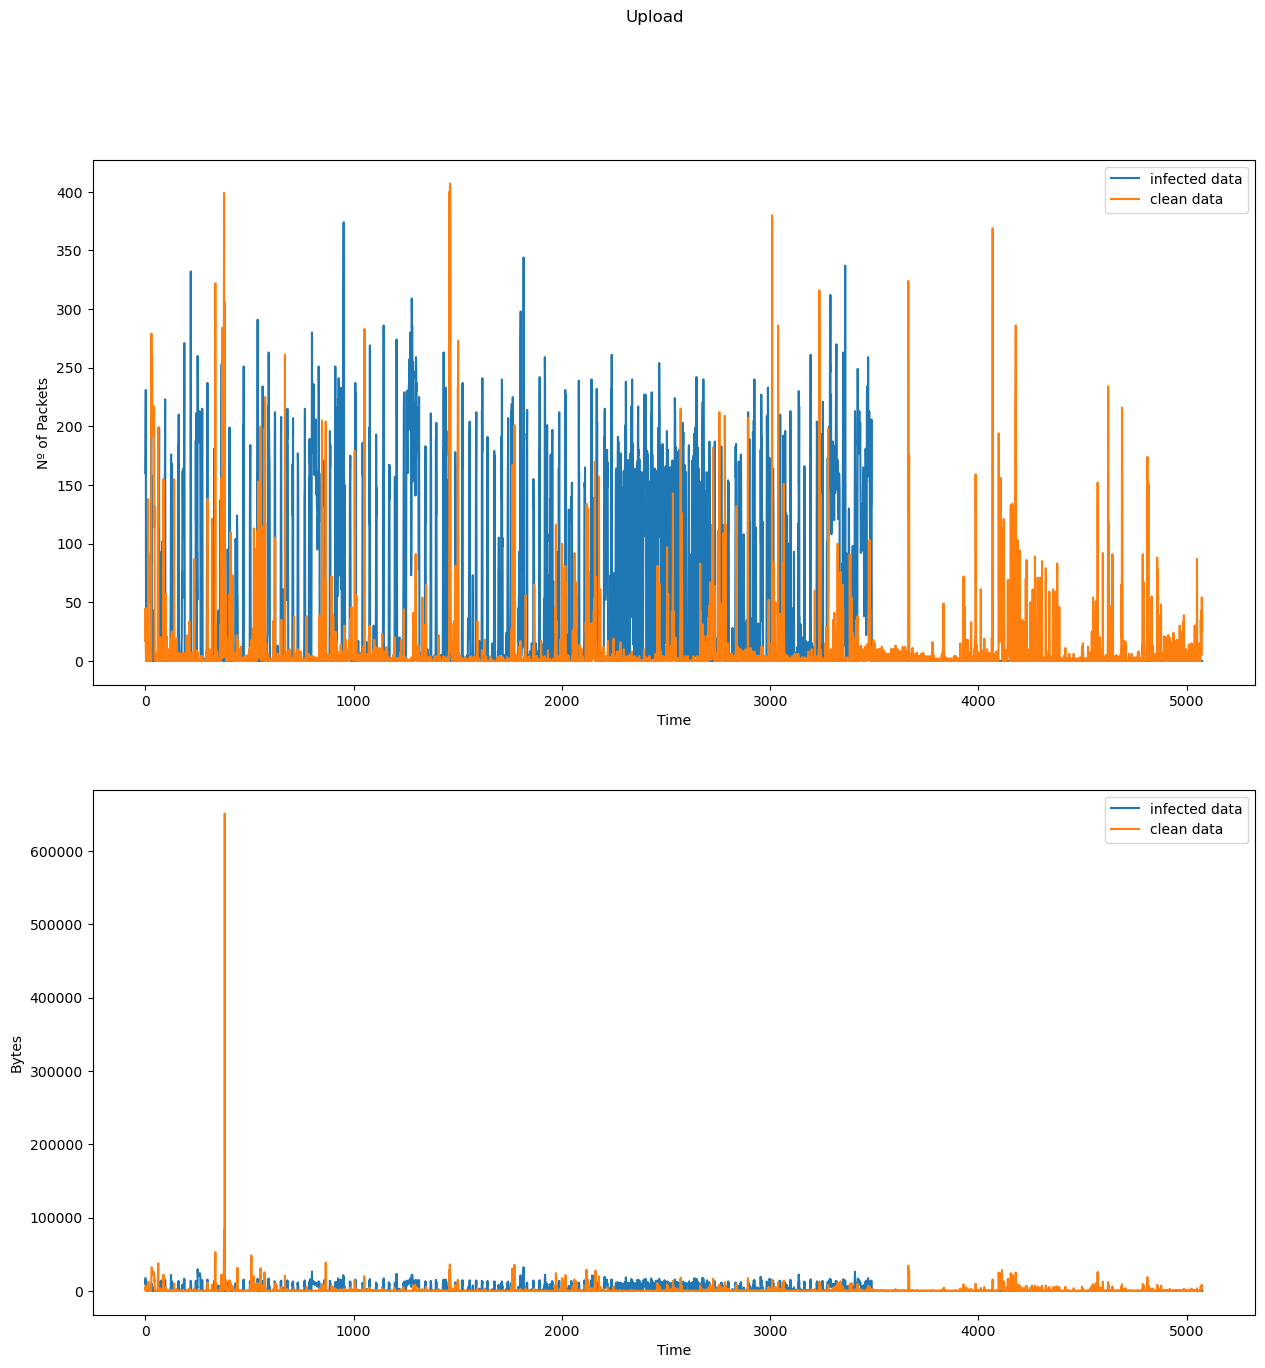

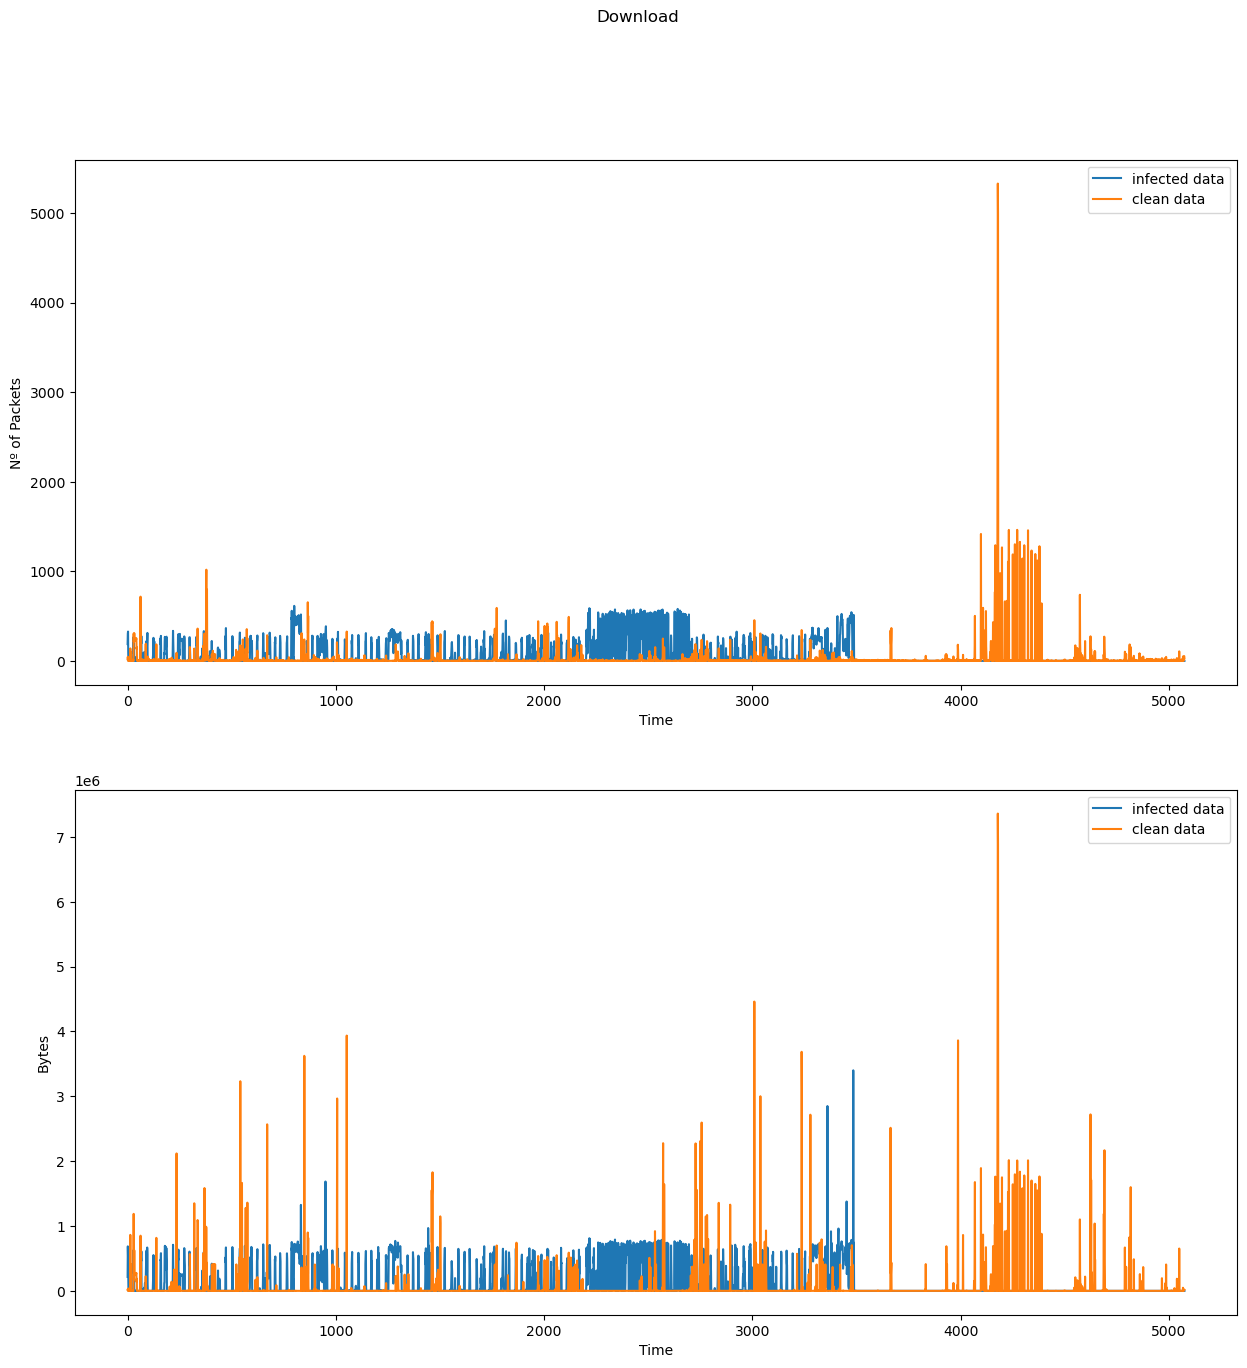

In [144]:
clean_data=np.loadtxt("clean_sampled_data.dat",dtype=int)
infected_data=np.loadtxt("infected_sampled_data.dat",dtype=int)
showChart_but_chatgpt_did_it_upload(clean_data,infected_data,"Upload")
showChart_but_chatgpt_did_it_download(clean_data,infected_data,"Download")


In [131]:
# Bytes over packets
def showChart_upload_ratio(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    # Calculate the average number of bytes per packet for each row
    clean_avg_bytes_per_packet =  [clean_data[x, 2] / clean_data[x, 1]  if clean_data[x,1]!=0 else 0 for x in range(clean_data.shape[0]) ]
    infected_avg_bytes_per_packet =[infected_data[x, 2] / infected_data[x, 1]  if infected_data[x,1]!=0 else 0 for x in range(infected_data.shape[0]) ]
 
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_avg_bytes_per_packet, label="infected data")
    plt.plot(clean_avg_bytes_per_packet, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Nº of Packets')
    plt.title("Upload")
    plt.legend()

    
    clean_avg_bytes_per_packet =  [clean_data[x, 4] / clean_data[x, 3]  if clean_data[x,3]!=0 else 0 for x in range(clean_data.shape[0]) ]
    infected_avg_bytes_per_packet =[infected_data[x, 4] / infected_data[x, 3]  if infected_data[x,3]!=0 else 0 for x in range(infected_data.shape[0]) ]
 


    plt.subplot(2,1,2)
    plt.plot(clean_avg_bytes_per_packet, label="infected data")
    plt.plot(infected_avg_bytes_per_packet, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.title("Download")
    plt.suptitle("Bytes/Packets Ratio")
    plt.show()
    
    

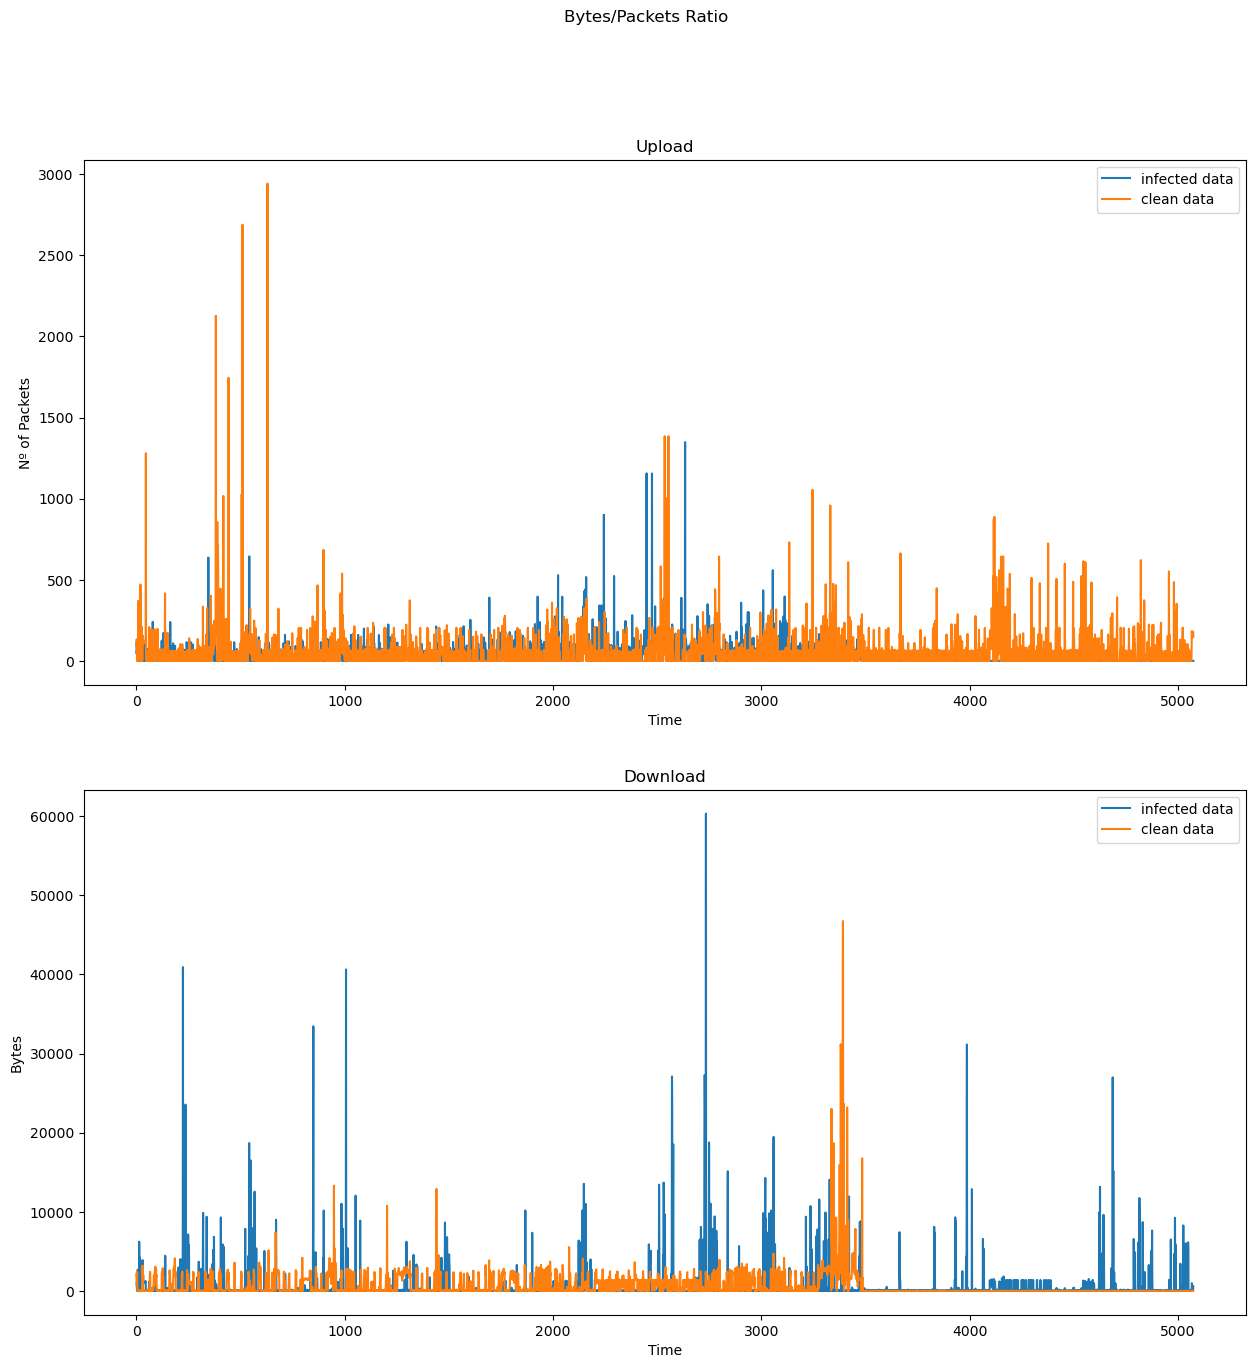

In [132]:
showChart_upload_ratio(clean_data,infected_data)


In [151]:
# Cumulative sum for evolution of packets/bytes

def showChart_bytes_csum(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    # Calculate the average number of bytes per packet for each row
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 2])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 2]) 
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.title("Upload")
    plt.legend()

    
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 4])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 4]) 
 


    plt.subplot(2,1,2)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.title("Download")
    plt.suptitle("Total Bytes Sent/Received")
    plt.show()

def showChart_packets_csum(clean_data, infected_data, name:str="placeholder"):
    diff = clean_data.shape[0] - infected_data.shape[0]
    if diff < 0:
        clean_data = np.pad(clean_data, ((0, diff), (0, 0)), mode="constant")
    elif diff > 0:
        infected_data = np.pad(infected_data, ((0, diff), (0, 0)), mode="constant")
    
    # Calculate the average number of bytes per packet for each row
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 1])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 1]) 
    plt.figure(figsize=(15, 15))
    plt.subplot(2,1,1)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Packets')
    plt.title("Upload")
    plt.legend()

    
    clean_cumulative_bytes_sent = np.cumsum(clean_data[:, 3])
    infected_cumulative_bytes_sent = np.cumsum(infected_data[:, 3]) 
 


    plt.subplot(2,1,2)
    plt.plot(infected_cumulative_bytes_sent, label="infected data")
    plt.plot(clean_cumulative_bytes_sent, label="clean data")
    plt.xlabel('Time')
    plt.ylabel('Packets')
    plt.legend()
    plt.title("Download")
    plt.suptitle("Total Packets Sent/Received")
    plt.show()

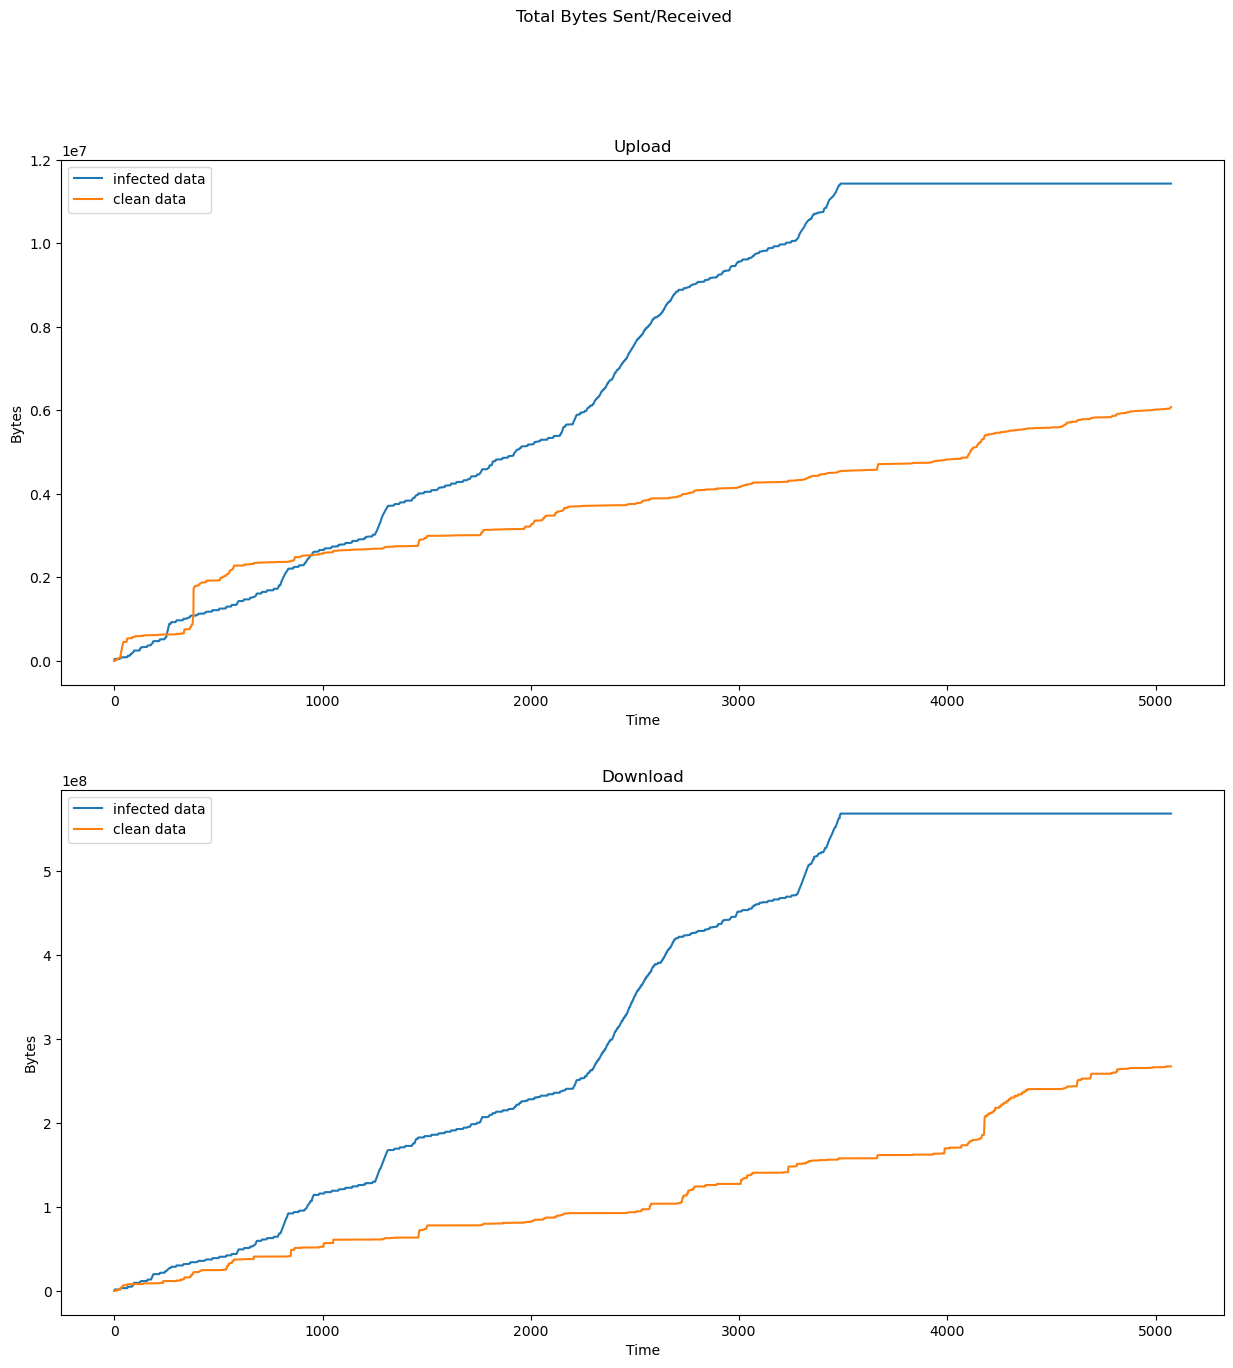

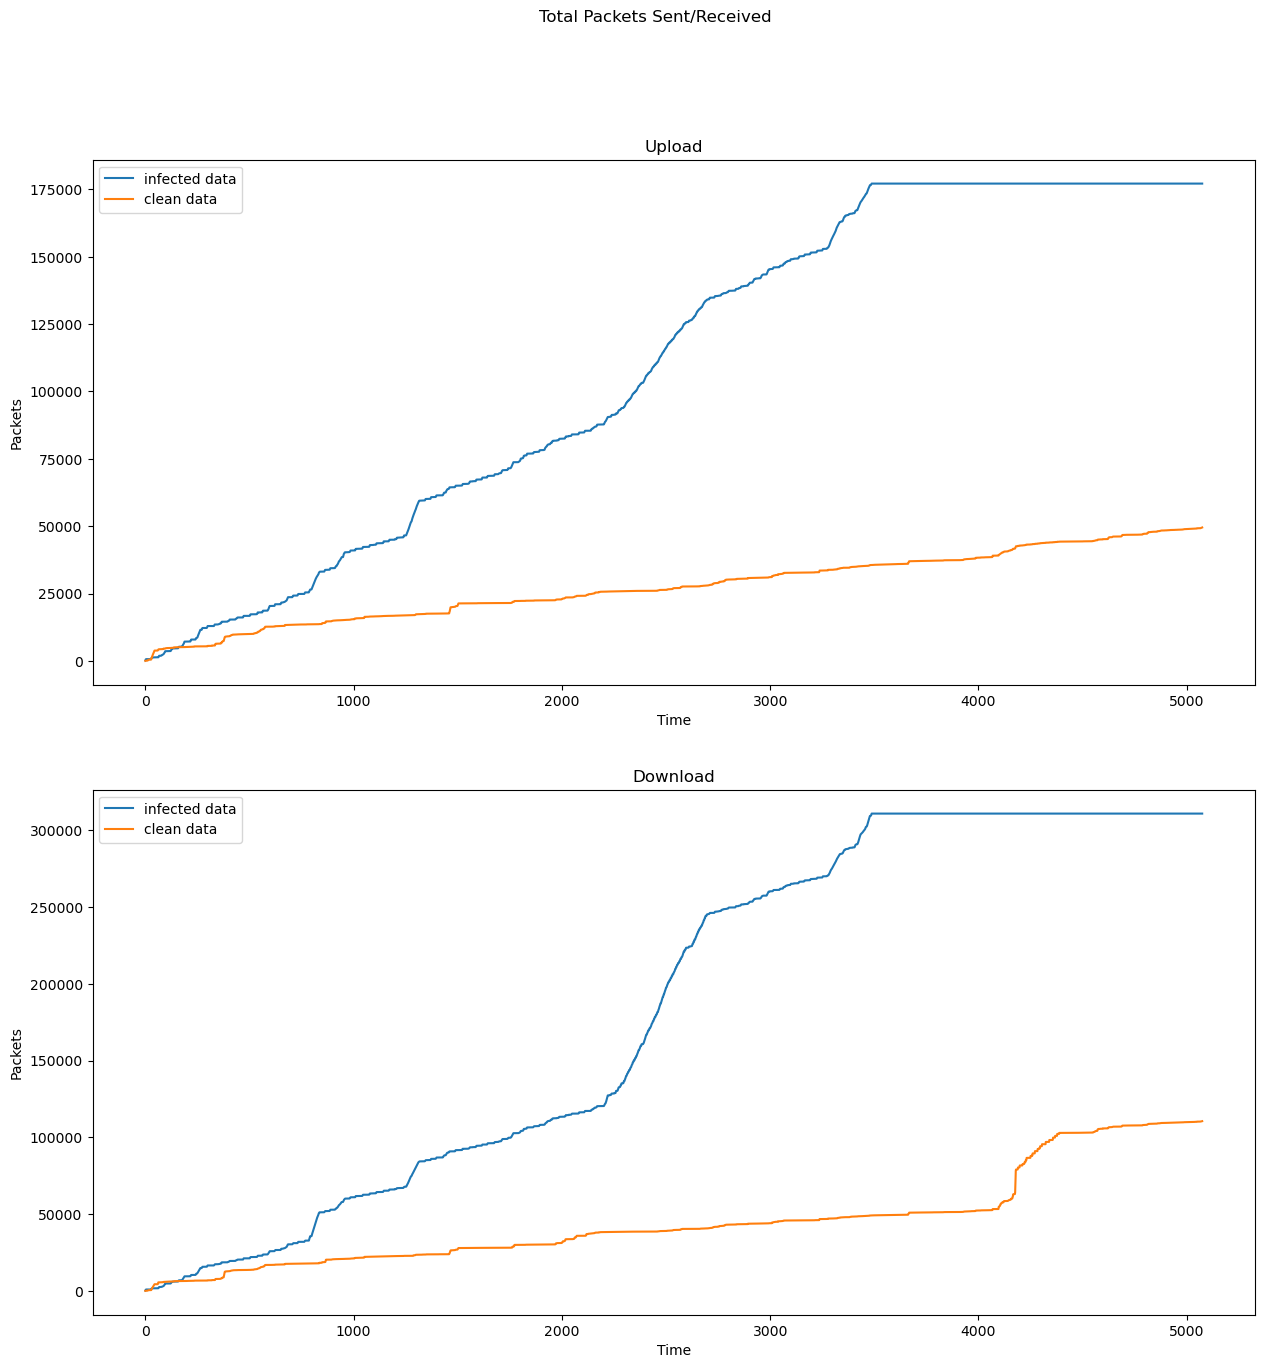

In [152]:
showChart_bytes_csum(clean_data,infected_data)
showChart_packets_csum(clean_data,infected_data)

In [150]:
# analyze with sliding window

import numpy as np
import matplotlib.pyplot as plt
import os

In [157]:
def slidingObsWindow(data,lengthObsWindow,slidingValue,basename):
    iobs=0
    nSamples,nMetrics=data.shape
    obsData=np.zeros((0,lengthObsWindow,nMetrics))
    for s in np.arange(lengthObsWindow,nSamples,slidingValue):
        subdata=data[s-lengthObsWindow:s,:]
        obsData=np.insert(obsData,iobs,subdata,axis=0)

        obsFname="{}_obs{}_w{}.dat".format(basename,iobs,lengthObsWindow)
        iobs+=1
        np.savetxt(obsFname,subdata,fmt='%d')

    return obsData # 3D arrays (obs, sample, metric)

In [158]:
fileInput="1_sampled_data.dat"
lengthObsWindow=[15]
slidingValue=3

data=np.loadtxt(fileInput,dtype=int)
fname=''.join(fileInput.split('.')[:-1])

dirname=fname+"_clean_obs_s{}_m{}".format(slidingValue,"2")

os.mkdir(dirname)
basename=dirname+"/"+fname

print("\n\n### SLIDING Observation Windows with Length {} and Sliding {} ###".format(lengthObsWindow[0],slidingValue))
obsData=slidingObsWindow(data,lengthObsWindow[0],slidingValue,basename)
print(obsData)



### SLIDING Observation Windows with Length 15 and Sliding 3 ###
[[[0.00000e+00 1.70000e+01 1.58900e+03 1.80000e+01 1.72150e+04]
  [1.00000e+00 4.50000e+01 5.98700e+03 4.50000e+01 2.75350e+04]
  [2.00000e+00 1.00000e+01 6.80000e+02 1.00000e+01 1.17300e+03]
  ...
  [1.20000e+01 1.60000e+01 2.79000e+03 1.60000e+01 1.89100e+03]
  [1.30000e+01 1.38000e+02 8.38200e+03 1.39000e+02 8.63539e+05]
  [1.40000e+01 5.00000e+01 1.26100e+04 5.40000e+01 2.32840e+04]]

 [[3.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
  [4.00000e+00 3.00000e+00 2.75000e+02 3.00000e+00 3.29700e+03]
  [5.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
  ...
  [1.50000e+01 9.10000e+01 1.19750e+04 9.70000e+01 4.11628e+05]
  [1.60000e+01 1.00000e+01 1.80500e+03 1.00000e+01 1.40600e+03]
  [1.70000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]

 [[6.00000e+00 1.40000e+01 8.03000e+02 1.40000e+01 3.74540e+04]
  [7.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
  [8.00000e+00 8.0000

In [159]:
# Extract Features
import argparse
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from baseObsWindows import slidingMultObsWindow
import os

def extractFeatures(dirname,basename,nObs,allwidths):
    for o in range(0,nObs):
        features=np.array([])
        for oW in allwidths:
            obsfilename=dirname+"/"+basename+str(o)+"_w"+str(oW)+".dat"
            # print(obsfilename)
            subdata=np.loadtxt(obsfilename)[:,1:]    #Loads data and removes first column (sample index)
                
            faux=extractStats(subdata)    
            features=np.hstack((features,faux))
            
            # faux2=extractStatsSilenceActivity(subdata)
            # features=np.hstack((features,faux2))
        if o==0:
            obsFeatures=features
        else:
            obsFeatures=np.vstack((obsFeatures,features))

    return obsFeatures


def extractStatsSilenceActivity(data):
    features=[]
    nSamples,nMetrics=data.shape
    silence_features=np.array([])
    activity_features=np.array([])
    for c in range(nMetrics):
        silence,activity=extratctSilenceActivity(data[:,c],threshold=0)
        
        if len(silence)>0:
            silence_faux=np.array([len(silence),np.mean(silence),np.std(silence)])
        else:
            silence_faux=np.zeros(3)
        silence_features=np.hstack((silence_features,silence_faux))
        
        if len(activity)>0:
            activity_faux=np.array([len(activity),np.mean(activity),np.std(activity)])
        else:
            activity_faux=np.zeros(3)
        activity_features=np.hstack((activity_features,activity_faux))       
            
    features=np.hstack((silence_features,activity_features))
        
    return(features)


def extratctSilenceActivity(data,threshold=0):
    if(data[0]<=threshold):
        s=[1]
        a=[]
    else:
        s=[]
        a=[1]
    for i in range(1,len(data)):
        if(data[i-1]>threshold and data[i]<=threshold):
            s.append(1)
        elif(data[i-1]<=threshold and data[i]>threshold):
            a.append(1)
        elif (data[i-1]<=threshold and data[i]<=threshold):
            s[-1]+=1
        else:
            a[-1]+=1
    return(s,a)

def extractStats(data):
    nSamp,nCols=data.shape

    M1=np.mean(data,axis=0)
    Md1=np.median(data,axis=0)
    Std1=np.std(data,axis=0)
    S1=stats.skew(data)
    #K1=stats.kurtosis(data)
    p=[75,90,95,98]
    Pr1=np.array(np.percentile(data,p,axis=0)).T.flatten()
        
    features=np.hstack((M1,Md1,Std1,S1,Pr1))
    return(features)


# 4 colunas (2*up+2*down) * (8 features + 6 do silence^(3*2)) 

# up_pack (0:media 1:mediana 2:std 3:skew 4:75p 5:90p 6:95p 7:98p //8:len(silence) 9:mean_silence 10:std_silence 11:len(activity) 12:mean_act 13:std_act) ) up_bytes


In [166]:
dirname="1_sampled_data_clean_obs_s3_m2"
allwidths=[15]

allfiles=os.listdir(dirname)
nObs=len([f for f in allfiles if '_w{}.'.format(allwidths[0]) in f])
lbn=allfiles[0].rfind("obs")+3
basename=allfiles[0][:lbn]

clean_features=extractFeatures(dirname,basename,nObs,allwidths)

outfilename=basename+"_cleanfeatures.dat"

np.savetxt(outfilename,features,fmt='%.4f')
print(clean_features)
print(clean_features.shape)

[[2.38000000e+01 3.23780000e+03 2.44666667e+01 ... 3.34864000e+04
  2.85279500e+05 6.32235200e+05]
 [2.57333333e+01 3.60606667e+03 2.67333333e+01 ... 2.61958400e+05
  5.47201300e+05 7.37003920e+05]
 [2.59333333e+01 3.77580000e+03 2.70000000e+01 ... 2.61958400e+05
  5.47201300e+05 7.37003920e+05]
 ...
 [2.13333333e+00 1.25333333e+02 2.20000000e+00 ... 3.57600000e+02
  6.05100000e+02 8.64240000e+02]
 [8.13333333e+00 1.20320000e+03 9.40000000e+00 ... 1.77468000e+04
  3.01658000e+04 4.07019200e+04]
 [1.40000000e+01 2.09300000e+03 1.46000000e+01 ... 1.93832000e+04
  3.01658000e+04 4.07019200e+04]]
(1687, 32)


In [179]:
import argparse
import scipy.stats as stats
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import scalogram
from baseObsWindows import slidingMultObsWindow
import os

def extractPeriodicityFeatures(dirname,basename,nObs,allwidths):
    for o in range(0,nObs):
        features=np.array([])
        for oW in allwidths:
            obsfilename=dirname+"/"+basename+str(o)+"_w"+str(oW)+".dat"
            #print(obsfilename)
            subdata=np.loadtxt(obsfilename)[:,1]    #Loads data, only second column
            
            scales=np.arange(2,50)                  
            S,scales=scalogram.scalogramCWT(subdata,scales)   #periodogram using CWT (Morlet wavelet)
            features=np.hstack((features,S))
            
            #f,psd=signal.periodogram(subdata)      #periodogram using the Welch's method
            #features=np.hstack((features,pad))
            
            #fft=np.fft.fft(subdata)                   #periodogram using basic modulus-squared of the discrete FFT
            #psd=abs(fft)**2
            #features=np.hstack((features,psd))
            
        if o==0:
            obsFeatures=features
        else:
            obsFeatures=np.vstack((obsFeatures,features))

    return obsFeatures

def slidingObsWindow(data,lengthObsWindow,slidingValue,basename):
    iobs=0
    nSamples,nMetrics=data.shape
    obsData=np.zeros((0,lengthObsWindow,nMetrics))
    for s in np.arange(lengthObsWindow,nSamples,slidingValue):
        subdata=data[s-lengthObsWindow:s,:]
        obsData=np.insert(obsData,iobs,subdata,axis=0)
        
        obsFname="{}_obs{}_w{}.dat".format(basename,iobs,lengthObsWindow)
        iobs+=1
        np.savetxt(obsFname,subdata,fmt='%.4f')
               
    return obsData # 3D arrays (obs, sample, metric)


[3.23780000e+03 3.60606670e+03 3.77580000e+03 3.70380000e+03
 2.98206670e+03 2.97186670e+03 7.90646670e+03 1.29126667e+04
 1.74459333e+04 2.20669333e+04 2.39321333e+04 1.82575333e+04
 1.30791333e+04 8.55653330e+03 3.67480000e+03 2.42266700e+02
 5.43226670e+03 5.55740000e+03 5.57960000e+03 5.57433330e+03
 5.83840000e+03 4.77666700e+02 3.82266700e+02 3.60066700e+02
 6.70400000e+02 1.90426670e+03 1.94453330e+03 1.90686670e+03
 2.68560000e+03 2.67093330e+03 1.28413330e+03 1.24840000e+03
 1.25633330e+03 5.25733300e+02 2.35333300e+02 1.32133300e+02
 1.62000000e+02 2.42000000e+02 2.52200000e+02 2.44266700e+02
 2.68933300e+02 2.82133300e+02 8.89000000e+02 8.06733300e+02
 8.54333300e+02 9.92466700e+02 1.13293330e+03 4.30200000e+02
 4.54000000e+02 4.15266700e+02 2.64933300e+02 6.89333000e+01
 9.27333000e+01 6.89333000e+01 7.59333000e+01 7.14000000e+01
 9.97333000e+01 7.59333000e+01 9.97333000e+01 7.59333000e+01
 8.04667000e+01 6.80000000e+01 1.81933300e+02 3.34000000e+02
 3.41933300e+02 3.304000

[1.90686670e+03 2.68560000e+03 2.67093330e+03 1.28413330e+03
 1.24840000e+03 1.25633330e+03 5.25733300e+02 2.35333300e+02
 1.32133300e+02 1.62000000e+02 2.42000000e+02 2.52200000e+02
 2.44266700e+02 2.68933300e+02 2.82133300e+02 8.89000000e+02
 8.06733300e+02 8.54333300e+02 9.92466700e+02 1.13293330e+03
 4.30200000e+02 4.54000000e+02 4.15266700e+02 2.64933300e+02
 6.89333000e+01 9.27333000e+01 6.89333000e+01 7.59333000e+01
 7.14000000e+01 9.97333000e+01 7.59333000e+01 9.97333000e+01
 7.59333000e+01 8.04667000e+01 6.80000000e+01 1.81933300e+02
 3.34000000e+02 3.41933300e+02 3.30400000e+02 5.60933300e+02
 4.77666700e+02 3.01800000e+02 3.15866700e+02 3.55066700e+02
 1.08666700e+02 9.28667000e+01 1.22600000e+02 3.52400000e+02
 2.96400000e+02 2.96400000e+02 2.86066700e+02 2.88466700e+02
 3.66667000e+01 1.03200000e+02 1.16800000e+02 1.12266700e+02
 8.01333000e+01 8.01333000e+01 3.04000000e+01 3.71333000e+01
 3.71333000e+01 3.71333000e+01 3.71333000e+01 2.48667000e+01
 4.53330000e+00 4.533300

[7.59333000e+01 7.14000000e+01 9.97333000e+01 7.59333000e+01
 9.97333000e+01 7.59333000e+01 8.04667000e+01 6.80000000e+01
 1.81933300e+02 3.34000000e+02 3.41933300e+02 3.30400000e+02
 5.60933300e+02 4.77666700e+02 3.01800000e+02 3.15866700e+02
 3.55066700e+02 1.08666700e+02 9.28667000e+01 1.22600000e+02
 3.52400000e+02 2.96400000e+02 2.96400000e+02 2.86066700e+02
 2.88466700e+02 3.66667000e+01 1.03200000e+02 1.16800000e+02
 1.12266700e+02 8.01333000e+01 8.01333000e+01 3.04000000e+01
 3.71333000e+01 3.71333000e+01 3.71333000e+01 3.71333000e+01
 2.48667000e+01 4.53330000e+00 4.53330000e+00 4.31333000e+01
 5.21333000e+01 8.24866700e+02 8.24866700e+02 8.24866700e+02
 8.42333300e+02 8.38666700e+02 7.04667000e+01 7.04667000e+01
 6.60200000e+02 6.29066700e+02 6.23733300e+02 6.14666700e+02
 6.14666700e+02 1.90206670e+03 5.90746670e+03 6.58053330e+03
 6.58506670e+03 6.64120000e+03 4.76940000e+03 7.39066700e+02
 6.60000000e+01 1.47066700e+02 3.90133300e+02 3.38160000e+03
 3.73160000e+03 6.697666

[8.01333000e+01 3.04000000e+01 3.71333000e+01 3.71333000e+01
 3.71333000e+01 3.71333000e+01 2.48667000e+01 4.53330000e+00
 4.53330000e+00 4.31333000e+01 5.21333000e+01 8.24866700e+02
 8.24866700e+02 8.24866700e+02 8.42333300e+02 8.38666700e+02
 7.04667000e+01 7.04667000e+01 6.60200000e+02 6.29066700e+02
 6.23733300e+02 6.14666700e+02 6.14666700e+02 1.90206670e+03
 5.90746670e+03 6.58053330e+03 6.58506670e+03 6.64120000e+03
 4.76940000e+03 7.39066700e+02 6.60000000e+01 1.47066700e+02
 3.90133300e+02 3.38160000e+03 3.73160000e+03 6.69766670e+03
 7.26906670e+03 1.04887333e+04 1.77010667e+04 6.30444667e+04
 6.07768667e+04 6.14500667e+04 5.85028667e+04 4.83149333e+04
 2.72673330e+03 2.15166670e+03 2.02420000e+03 1.95153330e+03
 2.83480000e+03 3.46080000e+03 4.09266670e+03 3.39953330e+03
 3.41660000e+03 2.51480000e+03 1.79153330e+03 1.17373330e+03
 6.71333300e+02 1.63200000e+02 6.60800000e+02 2.84140000e+03
 2.72240000e+03 2.71520000e+03 2.80413330e+03 2.31446670e+03
 1.44400000e+02 1.788667

[6.64120000e+03 4.76940000e+03 7.39066700e+02 6.60000000e+01
 1.47066700e+02 3.90133300e+02 3.38160000e+03 3.73160000e+03
 6.69766670e+03 7.26906670e+03 1.04887333e+04 1.77010667e+04
 6.30444667e+04 6.07768667e+04 6.14500667e+04 5.85028667e+04
 4.83149333e+04 2.72673330e+03 2.15166670e+03 2.02420000e+03
 1.95153330e+03 2.83480000e+03 3.46080000e+03 4.09266670e+03
 3.39953330e+03 3.41660000e+03 2.51480000e+03 1.79153330e+03
 1.17373330e+03 6.71333300e+02 1.63200000e+02 6.60800000e+02
 2.84140000e+03 2.72240000e+03 2.71520000e+03 2.80413330e+03
 2.31446670e+03 1.44400000e+02 1.78866700e+02 1.86066700e+02
 8.92000000e+01 9.18667000e+01 8.40000000e+01 3.90000000e+01
 6.35333000e+01 6.88667000e+01 5.82667000e+01 6.80667000e+01
 8.03333000e+01 5.58000000e+01 5.58000000e+01 1.44133300e+02
 2.45266700e+02 7.84933300e+02 4.06666670e+03 4.08460000e+03
 4.06646670e+03 4.01000000e+03 4.98746670e+03 2.21073330e+03
 2.41233330e+03 2.60620000e+03 3.45666670e+03 2.12466670e+03
 2.69833330e+03 3.511466

[1791.5333 1173.7333  671.3333  163.2     660.8    2841.4    2722.4
 2715.2    2804.1333 2314.4667  144.4     178.8667  186.0667   89.2
   91.8667   84.       39.       63.5333   68.8667   58.2667   68.0667
   80.3333   55.8      55.8     144.1333  245.2667  784.9333 4066.6667
 4084.6    4066.4667 4010.     4987.4667 2210.7333 2412.3333 2606.2
 3456.6667 2124.6667 2698.3333 3511.4667 3585.7333 3297.8    3477.8
 6533.9333 5842.9333 6252.6    5958.0667 6089.8667 2938.7333 4985.5333
 6971.8    6709.6667 6265.5333 5292.4667 2898.6667  221.6     150.6667
   83.       65.2      65.2      10.6667   10.6667    9.8667  170.9333
  178.8667  189.8667 1100.8    1120.1333 1645.     1653.8667 1658.7333
  755.7333  755.6667   87.5333   89.2      80.4667  408.9333  398.
  380.2     405.2667  403.4667  131.     1830.3333 1845.4667 1823.5333
 1856.4    2026.      348.2     337.6     388.6667  365.3333  131.8
  102.4     119.9333   47.2667   27.0667  154.8667  374.2     356.6667
  356.6667  423.8     296

[4066.6667 4084.6    4066.4667 4010.     4987.4667 2210.7333 2412.3333
 2606.2    3456.6667 2124.6667 2698.3333 3511.4667 3585.7333 3297.8
 3477.8    6533.9333 5842.9333 6252.6    5958.0667 6089.8667 2938.7333
 4985.5333 6971.8    6709.6667 6265.5333 5292.4667 2898.6667  221.6
  150.6667   83.       65.2      65.2      10.6667   10.6667    9.8667
  170.9333  178.8667  189.8667 1100.8    1120.1333 1645.     1653.8667
 1658.7333  755.7333  755.6667   87.5333   89.2      80.4667  408.9333
  398.      380.2     405.2667  403.4667  131.     1830.3333 1845.4667
 1823.5333 1856.4    2026.      348.2     337.6     388.6667  365.3333
  131.8     102.4     119.9333   47.2667   27.0667  154.8667  374.2
  356.6667  356.6667  423.8     296.      167.      184.5333  187.2
  187.4667  195.8667  135.6     161.6     158.9333   96.8667   88.4667
   53.4       9.8667   15.2      15.2      23.1333  385.6667  429.
  423.6667  441.2     449.1333  142.3333  113.8667  119.2     104.7333
   88.8667   38.4667  

[ 221.6     150.6667   83.       65.2      65.2      10.6667   10.6667
    9.8667  170.9333  178.8667  189.8667 1100.8    1120.1333 1645.
 1653.8667 1658.7333  755.7333  755.6667   87.5333   89.2      80.4667
  408.9333  398.      380.2     405.2667  403.4667  131.     1830.3333
 1845.4667 1823.5333 1856.4    2026.      348.2     337.6     388.6667
  365.3333  131.8     102.4     119.9333   47.2667   27.0667  154.8667
  374.2     356.6667  356.6667  423.8     296.      167.      184.5333
  187.2     187.4667  195.8667  135.6     161.6     158.9333   96.8667
   88.4667   53.4       9.8667   15.2      15.2      23.1333  385.6667
  429.      423.6667  441.2     449.1333  142.3333  113.8667  119.2
  104.7333   88.8667   38.4667   41.5333   36.2      33.1333   40.3333
   73.2      55.2667   60.6      60.6      61.3333  424.9333  420.4
  415.0667  412.4    1339.2667 1236.6667 1257.     1472.6667 2233.2
 1301.0667 4744.8667 5919.3333 5703.6667 4943.1333 4967.1333 1228.6667
   38.4      55.933

[1830.3333 1845.4667 1823.5333 1856.4    2026.      348.2     337.6
  388.6667  365.3333  131.8     102.4     119.9333   47.2667   27.0667
  154.8667  374.2     356.6667  356.6667  423.8     296.      167.
  184.5333  187.2     187.4667  195.8667  135.6     161.6     158.9333
   96.8667   88.4667   53.4       9.8667   15.2      15.2      23.1333
  385.6667  429.      423.6667  441.2     449.1333  142.3333  113.8667
  119.2     104.7333   88.8667   38.4667   41.5333   36.2      33.1333
   40.3333   73.2      55.2667   60.6      60.6      61.3333  424.9333
  420.4     415.0667  412.4    1339.2667 1236.6667 1257.     1472.6667
 2233.2    1301.0667 4744.8667 5919.3333 5703.6667 4943.1333 4967.1333
 1228.6667   38.4      55.9333   53.2667  117.2667  959.5333 1443.2
 1880.8667 2041.4    2120.4    1319.7333 1091.4     644.1333  572.
  410.2667  429.2     226.1333  249.9333  177.8667  394.4     386.5333
  380.3333  364.9333  388.3333  212.4667  436.      398.6667  564.5333
  532.7333  589.0667

[ 195.8667  135.6     161.6     158.9333   96.8667   88.4667   53.4
    9.8667   15.2      15.2      23.1333  385.6667  429.      423.6667
  441.2     449.1333  142.3333  113.8667  119.2     104.7333   88.8667
   38.4667   41.5333   36.2      33.1333   40.3333   73.2      55.2667
   60.6      60.6      61.3333  424.9333  420.4     415.0667  412.4
 1339.2667 1236.6667 1257.     1472.6667 2233.2    1301.0667 4744.8667
 5919.3333 5703.6667 4943.1333 4967.1333 1228.6667   38.4      55.9333
   53.2667  117.2667  959.5333 1443.2    1880.8667 2041.4    2120.4
 1319.7333 1091.4     644.1333  572.      410.2667  429.2     226.1333
  249.9333  177.8667  394.4     386.5333  380.3333  364.9333  388.3333
  212.4667  436.      398.6667  564.5333  532.7333  589.0667  369.3333
  392.8     221.2     410.1333  346.     1017.2667 1123.0667 1443.8667
 1295.8    1286.8     583.0667  552.2    1400.4667 1424.3333 1686.9333
 1690.6    1605.4     482.8667  426.0667  158.6     142.2667  144.6
  106.      170.2 

[  55.2667   60.6      60.6      61.3333  424.9333  420.4     415.0667
  412.4    1339.2667 1236.6667 1257.     1472.6667 2233.2    1301.0667
 4744.8667 5919.3333 5703.6667 4943.1333 4967.1333 1228.6667   38.4
   55.9333   53.2667  117.2667  959.5333 1443.2    1880.8667 2041.4
 2120.4    1319.7333 1091.4     644.1333  572.      410.2667  429.2
  226.1333  249.9333  177.8667  394.4     386.5333  380.3333  364.9333
  388.3333  212.4667  436.      398.6667  564.5333  532.7333  589.0667
  369.3333  392.8     221.2     410.1333  346.     1017.2667 1123.0667
 1443.8667 1295.8    1286.8     583.0667  552.2    1400.4667 1424.3333
 1686.9333 1690.6    1605.4     482.8667  426.0667  158.6     142.2667
  144.6     106.      170.2     159.1333  338.3333  379.5333 2548.9333
 2498.3333 2509.4    2330.2    2294.3333  129.4667  124.2667  284.8
  597.      627.5333  620.3333  623.      451.4     152.1333  141.6
  125.7333  190.1333  174.2667  196.2     144.7333  268.6     179.9333
  220.0667  169.3333 

[2041.4    2120.4    1319.7333 1091.4     644.1333  572.      410.2667
  429.2     226.1333  249.9333  177.8667  394.4     386.5333  380.3333
  364.9333  388.3333  212.4667  436.      398.6667  564.5333  532.7333
  589.0667  369.3333  392.8     221.2     410.1333  346.     1017.2667
 1123.0667 1443.8667 1295.8    1286.8     583.0667  552.2    1400.4667
 1424.3333 1686.9333 1690.6    1605.4     482.8667  426.0667  158.6
  142.2667  144.6     106.      170.2     159.1333  338.3333  379.5333
 2548.9333 2498.3333 2509.4    2330.2    2294.3333  129.4667  124.2667
  284.8     597.      627.5333  620.3333  623.      451.4     152.1333
  141.6     125.7333  190.1333  174.2667  196.2     144.7333  268.6
  179.9333  220.0667  169.3333  218.5333  120.8     158.2667  161.0667
  360.1333  554.1333  568.1333  530.6667  550.9333  371.2667  172.7333
  132.6     199.8     166.3333  165.9333  136.6     152.9333   83.0667
   74.2      55.2      58.0667   41.7333   68.6667  132.      188.0667
  443.2     

[1295.8    1286.8     583.0667  552.2    1400.4667 1424.3333 1686.9333
 1690.6    1605.4     482.8667  426.0667  158.6     142.2667  144.6
  106.      170.2     159.1333  338.3333  379.5333 2548.9333 2498.3333
 2509.4    2330.2    2294.3333  129.4667  124.2667  284.8     597.
  627.5333  620.3333  623.      451.4     152.1333  141.6     125.7333
  190.1333  174.2667  196.2     144.7333  268.6     179.9333  220.0667
  169.3333  218.5333  120.8     158.2667  161.0667  360.1333  554.1333
  568.1333  530.6667  550.9333  371.2667  172.7333  132.6     199.8
  166.3333  165.9333  136.6     152.9333   83.0667   74.2      55.2
   58.0667   41.7333   68.6667  132.      188.0667  443.2     451.1333
  432.6     356.3333  308.6667   49.6667   50.1333   49.6667  105.8667
  120.2667  305.4667  299.7333  302.8667  279.6     627.2     447.0667
  454.6667  446.2667  411.1333   51.3333   35.       27.4      30.4667
   27.4      27.0667   28.5333   66.7333   61.       69.4      67.0667
  523.1333  488.   

[ 623.      451.4     152.1333  141.6     125.7333  190.1333  174.2667
  196.2     144.7333  268.6     179.9333  220.0667  169.3333  218.5333
  120.8     158.2667  161.0667  360.1333  554.1333  568.1333  530.6667
  550.9333  371.2667  172.7333  132.6     199.8     166.3333  165.9333
  136.6     152.9333   83.0667   74.2      55.2      58.0667   41.7333
   68.6667  132.      188.0667  443.2     451.1333  432.6     356.3333
  308.6667   49.6667   50.1333   49.6667  105.8667  120.2667  305.4667
  299.7333  302.8667  279.6     627.2     447.0667  454.6667  446.2667
  411.1333   51.3333   35.       27.4      30.4667   27.4      27.0667
   28.5333   66.7333   61.       69.4      67.0667  523.1333  488.
 1277.4667 2325.2667 2486.4667 2068.8667 2068.4667 1281.6667  549.2667
  439.2667  393.6     396.6667  394.      124.4667  217.7333  222.2667
  216.5333  216.5333  229.8667  214.2667  581.      578.3333  578.3333
  523.2     389.0667   63.       65.6667   88.9333   73.8      73.8
   28.6      

[1.6593330e+02 1.3660000e+02 1.5293330e+02 8.3066700e+01 7.4200000e+01
 5.5200000e+01 5.8066700e+01 4.1733300e+01 6.8666700e+01 1.3200000e+02
 1.8806670e+02 4.4320000e+02 4.5113330e+02 4.3260000e+02 3.5633330e+02
 3.0866670e+02 4.9666700e+01 5.0133300e+01 4.9666700e+01 1.0586670e+02
 1.2026670e+02 3.0546670e+02 2.9973330e+02 3.0286670e+02 2.7960000e+02
 6.2720000e+02 4.4706670e+02 4.5466670e+02 4.4626670e+02 4.1113330e+02
 5.1333300e+01 3.5000000e+01 2.7400000e+01 3.0466700e+01 2.7400000e+01
 2.7066700e+01 2.8533300e+01 6.6733300e+01 6.1000000e+01 6.9400000e+01
 6.7066700e+01 5.2313330e+02 4.8800000e+02 1.2774667e+03 2.3252667e+03
 2.4864667e+03 2.0688667e+03 2.0684667e+03 1.2816667e+03 5.4926670e+02
 4.3926670e+02 3.9360000e+02 3.9666670e+02 3.9400000e+02 1.2446670e+02
 2.1773330e+02 2.2226670e+02 2.1653330e+02 2.1653330e+02 2.2986670e+02
 2.1426670e+02 5.8100000e+02 5.7833330e+02 5.7833330e+02 5.2320000e+02
 3.8906670e+02 6.3000000e+01 6.5666700e+01 8.8933300e+01 7.3800000e+01
 7.380

[3.0466700e+01 2.7400000e+01 2.7066700e+01 2.8533300e+01 6.6733300e+01
 6.1000000e+01 6.9400000e+01 6.7066700e+01 5.2313330e+02 4.8800000e+02
 1.2774667e+03 2.3252667e+03 2.4864667e+03 2.0688667e+03 2.0684667e+03
 1.2816667e+03 5.4926670e+02 4.3926670e+02 3.9360000e+02 3.9666670e+02
 3.9400000e+02 1.2446670e+02 2.1773330e+02 2.2226670e+02 2.1653330e+02
 2.1653330e+02 2.2986670e+02 2.1426670e+02 5.8100000e+02 5.7833330e+02
 5.7833330e+02 5.2320000e+02 3.8906670e+02 6.3000000e+01 6.5666700e+01
 8.8933300e+01 7.3800000e+01 7.3800000e+01 2.8600000e+01 2.5933300e+01
 2.6667000e+00 2.3800000e+01 3.3600000e+01 3.8133300e+01 8.4333300e+01
 1.4006670e+02 1.2686670e+02 1.4200000e+02 3.0253330e+02 2.7653330e+02
 2.2080000e+02 2.1286670e+02 1.8980000e+02 2.9266700e+01 9.0667000e+00
 5.2400000e+01 5.2400000e+01 4.7866700e+01 8.4200000e+01 8.4200000e+01
 4.0866700e+01 4.8800000e+01 6.1000000e+01 6.8200000e+01 7.7533300e+01
 3.3302667e+03 7.6120000e+03 9.8416000e+03 1.0064000e+04 1.0082400e+04
 6.829

[5.7833330e+02 5.2320000e+02 3.8906670e+02 6.3000000e+01 6.5666700e+01
 8.8933300e+01 7.3800000e+01 7.3800000e+01 2.8600000e+01 2.5933300e+01
 2.6667000e+00 2.3800000e+01 3.3600000e+01 3.8133300e+01 8.4333300e+01
 1.4006670e+02 1.2686670e+02 1.4200000e+02 3.0253330e+02 2.7653330e+02
 2.2080000e+02 2.1286670e+02 1.8980000e+02 2.9266700e+01 9.0667000e+00
 5.2400000e+01 5.2400000e+01 4.7866700e+01 8.4200000e+01 8.4200000e+01
 4.0866700e+01 4.8800000e+01 6.1000000e+01 6.8200000e+01 7.7533300e+01
 3.3302667e+03 7.6120000e+03 9.8416000e+03 1.0064000e+04 1.0082400e+04
 6.8296667e+03 2.5400000e+03 5.9500000e+02 4.1973330e+02 6.7766670e+02
 2.0903333e+03 2.4165333e+03 2.2121333e+03 2.8530667e+03 4.9234000e+03
 3.8412000e+03 3.5496667e+03 3.4626000e+03 2.7310000e+03 3.8986670e+02
 6.4733300e+01 3.0066700e+01 3.2666700e+01 2.8133300e+01 1.8600000e+01
 2.2866700e+01 6.3733300e+01 6.3000000e+01 6.7533300e+01 6.2200000e+01
 5.5266700e+01 1.4400000e+01 5.0533300e+01 4.6000000e+01 4.8666700e+01
 8.686

[4.7866700e+01 8.4200000e+01 8.4200000e+01 4.0866700e+01 4.8800000e+01
 6.1000000e+01 6.8200000e+01 7.7533300e+01 3.3302667e+03 7.6120000e+03
 9.8416000e+03 1.0064000e+04 1.0082400e+04 6.8296667e+03 2.5400000e+03
 5.9500000e+02 4.1973330e+02 6.7766670e+02 2.0903333e+03 2.4165333e+03
 2.2121333e+03 2.8530667e+03 4.9234000e+03 3.8412000e+03 3.5496667e+03
 3.4626000e+03 2.7310000e+03 3.8986670e+02 6.4733300e+01 3.0066700e+01
 3.2666700e+01 2.8133300e+01 1.8600000e+01 2.2866700e+01 6.3733300e+01
 6.3000000e+01 6.7533300e+01 6.2200000e+01 5.5266700e+01 1.4400000e+01
 5.0533300e+01 4.6000000e+01 4.8666700e+01 8.6866700e+01 8.6866700e+01
 4.6200000e+01 5.0733300e+01 4.8066700e+01 2.9266700e+01 2.9266700e+01
 3.1933300e+01 2.7400000e+01 2.7400000e+01 2.1046670e+02 2.5133330e+02
 2.5380000e+02 2.6600000e+02 2.6600000e+02 6.0866700e+01 2.0000000e+01
 1.0193330e+02 8.9733300e+01 9.4266700e+01 9.4266700e+01 9.4266700e+01
 2.2040000e+02 2.2493330e+02 2.6126670e+02 2.6126670e+02 2.6126670e+02
 4.540

[3.2666700e+01 2.8133300e+01 1.8600000e+01 2.2866700e+01 6.3733300e+01
 6.3000000e+01 6.7533300e+01 6.2200000e+01 5.5266700e+01 1.4400000e+01
 5.0533300e+01 4.6000000e+01 4.8666700e+01 8.6866700e+01 8.6866700e+01
 4.6200000e+01 5.0733300e+01 4.8066700e+01 2.9266700e+01 2.9266700e+01
 3.1933300e+01 2.7400000e+01 2.7400000e+01 2.1046670e+02 2.5133330e+02
 2.5380000e+02 2.6600000e+02 2.6600000e+02 6.0866700e+01 2.0000000e+01
 1.0193330e+02 8.9733300e+01 9.4266700e+01 9.4266700e+01 9.4266700e+01
 2.2040000e+02 2.2493330e+02 2.6126670e+02 2.6126670e+02 2.6126670e+02
 4.5400000e+01 4.0866700e+01 0.0000000e+00 0.0000000e+00 4.3533300e+01
 4.3533300e+01 4.8066700e+01 5.2600000e+01 5.2600000e+01 9.0667000e+00
 9.0667000e+00 4.5333000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.3200000e+01 2.2266700e+01 2.2266700e+01 2.2266700e+01 6.5600000e+01
 7.7333300e+01 6.8266700e+01 6.8266700e+01 6.8266700e+01 6.5800000e+01
 4.0866700e+01 4.9933300e+01 4.9933300e+01 4.9933300e+01 9.0667000e+00
 1.173

[1.0193330e+02 8.9733300e+01 9.4266700e+01 9.4266700e+01 9.4266700e+01
 2.2040000e+02 2.2493330e+02 2.6126670e+02 2.6126670e+02 2.6126670e+02
 4.5400000e+01 4.0866700e+01 0.0000000e+00 0.0000000e+00 4.3533300e+01
 4.3533300e+01 4.8066700e+01 5.2600000e+01 5.2600000e+01 9.0667000e+00
 9.0667000e+00 4.5333000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.3200000e+01 2.2266700e+01 2.2266700e+01 2.2266700e+01 6.5600000e+01
 7.7333300e+01 6.8266700e+01 6.8266700e+01 6.8266700e+01 6.5800000e+01
 4.0866700e+01 4.9933300e+01 4.9933300e+01 4.9933300e+01 9.0667000e+00
 1.1733300e+01 4.3533300e+01 4.3533300e+01 4.3533300e+01 4.3533300e+01
 4.8800000e+01 1.7000000e+01 4.3693330e+02 1.0071333e+03 4.5210667e+03
 4.6008000e+03 5.0414667e+03 7.8611333e+03 7.2909333e+03 3.7770000e+03
 3.7186000e+03 3.3167333e+03 1.2066670e+02 1.2520000e+02 1.2520000e+02
 1.8706670e+02 1.3920000e+02 2.7260000e+02 2.6806670e+02 2.6806670e+02
 1.7693330e+02 1.9106670e+02 1.4133300e+01 1.4133300e+01 3.0466700e+01
 3.181

[7.7333300e+01 6.8266700e+01 6.8266700e+01 6.8266700e+01 6.5800000e+01
 4.0866700e+01 4.9933300e+01 4.9933300e+01 4.9933300e+01 9.0667000e+00
 1.1733300e+01 4.3533300e+01 4.3533300e+01 4.3533300e+01 4.3533300e+01
 4.8800000e+01 1.7000000e+01 4.3693330e+02 1.0071333e+03 4.5210667e+03
 4.6008000e+03 5.0414667e+03 7.8611333e+03 7.2909333e+03 3.7770000e+03
 3.7186000e+03 3.3167333e+03 1.2066670e+02 1.2520000e+02 1.2520000e+02
 1.8706670e+02 1.3920000e+02 2.7260000e+02 2.6806670e+02 2.6806670e+02
 1.7693330e+02 1.9106670e+02 1.4133300e+01 1.4133300e+01 3.0466700e+01
 3.1813330e+02 3.4733330e+02 3.4733330e+02 3.4733330e+02 3.3100000e+02
 8.4200000e+01 8.8933300e+01 8.8933300e+01 9.3466700e+01 9.3466700e+01
 5.2600000e+01 4.5333000e+00 1.2620000e+02 1.2166670e+02 3.2080000e+02
 3.2080000e+02 3.2533330e+02 2.1140000e+02 3.0946670e+02 1.1033330e+02
 1.1826670e+02 1.1826670e+02 1.1053330e+02 1.2466700e+01 1.2466700e+01
 6.6400000e+01 7.4066700e+01 1.1473330e+02 1.1473330e+02 1.1473330e+02
 5.286

[1.2066670e+02 1.2520000e+02 1.2520000e+02 1.8706670e+02 1.3920000e+02
 2.7260000e+02 2.6806670e+02 2.6806670e+02 1.7693330e+02 1.9106670e+02
 1.4133300e+01 1.4133300e+01 3.0466700e+01 3.1813330e+02 3.4733330e+02
 3.4733330e+02 3.4733330e+02 3.3100000e+02 8.4200000e+01 8.8933300e+01
 8.8933300e+01 9.3466700e+01 9.3466700e+01 5.2600000e+01 4.5333000e+00
 1.2620000e+02 1.2166670e+02 3.2080000e+02 3.2080000e+02 3.2533330e+02
 2.1140000e+02 3.0946670e+02 1.1033330e+02 1.1826670e+02 1.1826670e+02
 1.1053330e+02 1.2466700e+01 1.2466700e+01 6.6400000e+01 7.4066700e+01
 1.1473330e+02 1.1473330e+02 1.1473330e+02 5.2866700e+01 8.4200000e+01
 5.1466700e+01 5.1466700e+01 5.6000000e+01 5.8666700e+01 8.8533300e+01
 8.0600000e+01 8.0600000e+01 8.4000000e+01 8.1333300e+01 7.9333000e+00
 7.9333000e+00 7.9333000e+00 4.5333000e+00 1.2466700e+01 1.7000000e+01
 1.9186670e+02 9.5373330e+02 3.2318667e+03 3.7682000e+03 3.7742667e+03
 3.6448000e+03 2.8829333e+03 6.0026670e+02 5.6000000e+01 2.8673330e+02
 4.913

[2.1140000e+02 3.0946670e+02 1.1033330e+02 1.1826670e+02 1.1826670e+02
 1.1053330e+02 1.2466700e+01 1.2466700e+01 6.6400000e+01 7.4066700e+01
 1.1473330e+02 1.1473330e+02 1.1473330e+02 5.2866700e+01 8.4200000e+01
 5.1466700e+01 5.1466700e+01 5.6000000e+01 5.8666700e+01 8.8533300e+01
 8.0600000e+01 8.0600000e+01 8.4000000e+01 8.1333300e+01 7.9333000e+00
 7.9333000e+00 7.9333000e+00 4.5333000e+00 1.2466700e+01 1.7000000e+01
 1.9186670e+02 9.5373330e+02 3.2318667e+03 3.7682000e+03 3.7742667e+03
 3.6448000e+03 2.8829333e+03 6.0026670e+02 5.6000000e+01 2.8673330e+02
 4.9133330e+02 1.9150000e+03 3.3329333e+03 4.3486000e+03 4.1481333e+03
 4.4412667e+03 4.5372000e+03 6.2979333e+03 5.2998000e+03 5.2634667e+03
 4.7203333e+03 3.2522000e+03 8.8400000e+01 7.0866700e+01 6.6333300e+01
 6.6333300e+01 1.4866700e+01 0.0000000e+00 4.7866700e+01 9.9760000e+02
 1.1768667e+03 3.0907333e+03 4.4506000e+03 4.5052667e+03 5.1878667e+03
 6.4319333e+03 4.5180667e+03 3.1582000e+03 3.0602000e+03 1.4324000e+03
 2.002

[ 191.8667  953.7333 3231.8667 3768.2    3774.2667 3644.8    2882.9333
  600.2667   56.      286.7333  491.3333 1915.     3332.9333 4348.6
 4148.1333 4441.2667 4537.2    6297.9333 5299.8    5263.4667 4720.3333
 3252.2      88.4      70.8667   66.3333   66.3333   14.8667    0.
   47.8667  997.6    1176.8667 3090.7333 4450.6    4505.2667 5187.8667
 6431.9333 4518.0667 3158.2    3060.2    1432.4     200.2667  200.2667
  200.2667  243.8667  239.3333   91.6667   91.6667   91.6667   43.5333
  558.2667 2281.4    4214.4667 4471.2    5488.7333 5864.4667 4100.4667
 2167.4    2268.5333 1665.9333  803.7333 1028.4667 1347.2667 1335.4
 1574.3333 2991.9333 4608.9333 4658.8    4315.4667 3677.6    2244.2667
  399.8667 1375.4    1386.0667 1851.2667 1854.6667 1867.2     523.
  509.6667  244.8     246.4     233.8667  247.1333  273.6667   65.2667
   76.1333  423.8667  426.4667  399.9333  397.3333  381.4667   41.6667
   39.0667   75.4      78.      454.8667  452.2667  444.3333  451.5333
  461.9333  142.    

[0.0000000e+00 4.7866700e+01 9.9760000e+02 1.1768667e+03 3.0907333e+03
 4.4506000e+03 4.5052667e+03 5.1878667e+03 6.4319333e+03 4.5180667e+03
 3.1582000e+03 3.0602000e+03 1.4324000e+03 2.0026670e+02 2.0026670e+02
 2.0026670e+02 2.4386670e+02 2.3933330e+02 9.1666700e+01 9.1666700e+01
 9.1666700e+01 4.3533300e+01 5.5826670e+02 2.2814000e+03 4.2144667e+03
 4.4712000e+03 5.4887333e+03 5.8644667e+03 4.1004667e+03 2.1674000e+03
 2.2685333e+03 1.6659333e+03 8.0373330e+02 1.0284667e+03 1.3472667e+03
 1.3354000e+03 1.5743333e+03 2.9919333e+03 4.6089333e+03 4.6588000e+03
 4.3154667e+03 3.6776000e+03 2.2442667e+03 3.9986670e+02 1.3754000e+03
 1.3860667e+03 1.8512667e+03 1.8546667e+03 1.8672000e+03 5.2300000e+02
 5.0966670e+02 2.4480000e+02 2.4640000e+02 2.3386670e+02 2.4713330e+02
 2.7366670e+02 6.5266700e+01 7.6133300e+01 4.2386670e+02 4.2646670e+02
 3.9993330e+02 3.9733330e+02 3.8146670e+02 4.1666700e+01 3.9066700e+01
 7.5400000e+01 7.8000000e+01 4.5486670e+02 4.5226670e+02 4.4433330e+02
 4.515

[5.8644667e+03 4.1004667e+03 2.1674000e+03 2.2685333e+03 1.6659333e+03
 8.0373330e+02 1.0284667e+03 1.3472667e+03 1.3354000e+03 1.5743333e+03
 2.9919333e+03 4.6089333e+03 4.6588000e+03 4.3154667e+03 3.6776000e+03
 2.2442667e+03 3.9986670e+02 1.3754000e+03 1.3860667e+03 1.8512667e+03
 1.8546667e+03 1.8672000e+03 5.2300000e+02 5.0966670e+02 2.4480000e+02
 2.4640000e+02 2.3386670e+02 2.4713330e+02 2.7366670e+02 6.5266700e+01
 7.6133300e+01 4.2386670e+02 4.2646670e+02 3.9993330e+02 3.9733330e+02
 3.8146670e+02 4.1666700e+01 3.9066700e+01 7.5400000e+01 7.8000000e+01
 4.5486670e+02 4.5226670e+02 4.4433330e+02 4.5153330e+02 4.6193330e+02
 1.4200000e+02 1.8233330e+02 1.9820000e+02 1.7060000e+02 1.7780000e+02
 1.6173330e+02 1.9026670e+02 1.6906670e+02 1.5313330e+02 1.3026670e+02
 8.6733300e+01 7.6600000e+01 1.0633330e+02 1.0633330e+02 1.2860000e+02
 1.3120000e+02 6.7133300e+01 3.7400000e+01 5.3733300e+01 2.8800000e+01
 5.0600000e+01 8.0333300e+01 1.1006670e+02 1.0860000e+02 1.4820000e+02
 1.521

[ 247.1333  273.6667   65.2667   76.1333  423.8667  426.4667  399.9333
  397.3333  381.4667   41.6667   39.0667   75.4      78.      454.8667
  452.2667  444.3333  451.5333  461.9333  142.      182.3333  198.2
  170.6     177.8     161.7333  190.2667  169.0667  153.1333  130.2667
   86.7333   76.6     106.3333  106.3333  128.6     131.2      67.1333
   37.4      53.7333   28.8      50.6      80.3333  110.0667  108.6
  148.2     152.1333  122.4      92.6667  121.1333  111.2667  121.1333
  121.1333  128.3333   85.       63.2      15.1333   30.       22.8
   22.8      14.8667   19.4       4.5333    4.5333    9.0667   57.2
   52.6667   96.2     104.2     137.8667   89.7333   94.2667   50.7333
   57.6      67.2667   67.2667   62.7333   62.7333   47.8667    0.
    0.        4.5333    4.5333   37.7333   37.7333   42.2667  760.2667
  898.1333 1003.4    1722.0667 1773.5333 1083.2667  948.0667  867.0667
  169.5333  113.5333  124.6     121.9333   64.4667   43.3333  216.7333
  314.6667 1127.7333 1

[ 130.2667   86.7333   76.6     106.3333  106.3333  128.6     131.2
   67.1333   37.4      53.7333   28.8      50.6      80.3333  110.0667
  108.6     148.2     152.1333  122.4      92.6667  121.1333  111.2667
  121.1333  121.1333  128.3333   85.       63.2      15.1333   30.
   22.8      22.8      14.8667   19.4       4.5333    4.5333    9.0667
   57.2      52.6667   96.2     104.2     137.8667   89.7333   94.2667
   50.7333   57.6      67.2667   67.2667   62.7333   62.7333   47.8667
    0.        0.        4.5333    4.5333   37.7333   37.7333   42.2667
  760.2667  898.1333 1003.4    1722.0667 1773.5333 1083.2667  948.0667
  867.0667  169.5333  113.5333  124.6     121.9333   64.4667   43.3333
  216.7333  314.6667 1127.7333 1584.3333 1589.6667 1416.2667 1355.4
  590.0667  279.7333  456.4     619.9333 2141.6    3038.5333 3329.7333
 3147.7333 3451.0667 1849.      947.8667  695.0667  695.0667  228.2
  232.7333  362.     1953.3333 2226.     2757.8667 2902.4    2729.6
  953.6     680.9333  

[  30.       22.8      22.8      14.8667   19.4       4.5333    4.5333
    9.0667   57.2      52.6667   96.2     104.2     137.8667   89.7333
   94.2667   50.7333   57.6      67.2667   67.2667   62.7333   62.7333
   47.8667    0.        0.        4.5333    4.5333   37.7333   37.7333
   42.2667  760.2667  898.1333 1003.4    1722.0667 1773.5333 1083.2667
  948.0667  867.0667  169.5333  113.5333  124.6     121.9333   64.4667
   43.3333  216.7333  314.6667 1127.7333 1584.3333 1589.6667 1416.2667
 1355.4     590.0667  279.7333  456.4     619.9333 2141.6    3038.5333
 3329.7333 3147.7333 3451.0667 1849.      947.8667  695.0667  695.0667
  228.2     232.7333  362.     1953.3333 2226.     2757.8667 2902.4
 2729.6     953.6     680.9333  208.4667   92.2667  108.1333  110.8
  156.9333  122.4667   89.6      73.7333   71.0667   24.9333    0.
    4.5333    4.5333    9.0667   52.4      70.9333   66.4      66.4
   61.8667   18.5333   39.6667   52.1333   64.6      64.6     178.3333
  983.8     986.266

[  37.7333   42.2667  760.2667  898.1333 1003.4    1722.0667 1773.5333
 1083.2667  948.0667  867.0667  169.5333  113.5333  124.6     121.9333
   64.4667   43.3333  216.7333  314.6667 1127.7333 1584.3333 1589.6667
 1416.2667 1355.4     590.0667  279.7333  456.4     619.9333 2141.6
 3038.5333 3329.7333 3147.7333 3451.0667 1849.      947.8667  695.0667
  695.0667  228.2     232.7333  362.     1953.3333 2226.     2757.8667
 2902.4    2729.6     953.6     680.9333  208.4667   92.2667  108.1333
  110.8     156.9333  122.4667   89.6      73.7333   71.0667   24.9333
    0.        4.5333    4.5333    9.0667   52.4      70.9333   66.4
   66.4      61.8667   18.5333   39.6667   52.1333   64.6      64.6
  178.3333  983.8     986.2667 1086.4667 1086.4667 1154.4667  314.
  417.      420.5333  497.6667  343.5333  416.      452.2667  490.4
  758.1333 1259.3333 1859.4667 1739.3333 1631.2    1433.2    1991.8667
 2536.2667 2868.4667 2932.     3034.     1984.0667  778.2667  448.7333
  395.6     581.0667  

[2141.6    3038.5333 3329.7333 3147.7333 3451.0667 1849.      947.8667
  695.0667  695.0667  228.2     232.7333  362.     1953.3333 2226.
 2757.8667 2902.4    2729.6     953.6     680.9333  208.4667   92.2667
  108.1333  110.8     156.9333  122.4667   89.6      73.7333   71.0667
   24.9333    0.        4.5333    4.5333    9.0667   52.4      70.9333
   66.4      66.4      61.8667   18.5333   39.6667   52.1333   64.6
   64.6     178.3333  983.8     986.2667 1086.4667 1086.4667 1154.4667
  314.      417.      420.5333  497.6667  343.5333  416.      452.2667
  490.4     758.1333 1259.3333 1859.4667 1739.3333 1631.2    1433.2
 1991.8667 2536.2667 2868.4667 2932.     3034.     1984.0667  778.2667
  448.7333  395.6     581.0667  586.6    1469.3333 1443.6667 1436.4
 1242.9333 1606.1333  729.1333  743.5333 1062.4667  944.0667 1759.0667
 2571.6667 3173.1333 2812.8    2826.     1878.4    1236.5333  637.6667
  654.      534.2     300.6667  116.2667  163.9333  155.5333  171.8667
  155.5333  179.8  

[  71.0667   24.9333    0.        4.5333    4.5333    9.0667   52.4
   70.9333   66.4      66.4      61.8667   18.5333   39.6667   52.1333
   64.6      64.6     178.3333  983.8     986.2667 1086.4667 1086.4667
 1154.4667  314.      417.      420.5333  497.6667  343.5333  416.
  452.2667  490.4     758.1333 1259.3333 1859.4667 1739.3333 1631.2
 1433.2    1991.8667 2536.2667 2868.4667 2932.     3034.     1984.0667
  778.2667  448.7333  395.6     581.0667  586.6    1469.3333 1443.6667
 1436.4    1242.9333 1606.1333  729.1333  743.5333 1062.4667  944.0667
 1759.0667 2571.6667 3173.1333 2812.8    2826.     1878.4    1236.5333
  637.6667  654.      534.2     300.6667  116.2667  163.9333  155.5333
  171.8667  155.5333  179.8     116.5333  197.6667  885.4     869.5333
  885.4     888.8     824.      124.2     156.4     108.3333  133.7333
  109.4667  121.5333   89.3333  121.5333   80.2667  162.2667  130.0667
  154.3333  139.5333 1331.4667 1256.4    1280.6667 1253.     1368.0667
  176.1333  185.

[ 416.      452.2667  490.4     758.1333 1259.3333 1859.4667 1739.3333
 1631.2    1433.2    1991.8667 2536.2667 2868.4667 2932.     3034.
 1984.0667  778.2667  448.7333  395.6     581.0667  586.6    1469.3333
 1443.6667 1436.4    1242.9333 1606.1333  729.1333  743.5333 1062.4667
  944.0667 1759.0667 2571.6667 3173.1333 2812.8    2826.     1878.4
 1236.5333  637.6667  654.      534.2     300.6667  116.2667  163.9333
  155.5333  171.8667  155.5333  179.8     116.5333  197.6667  885.4
  869.5333  885.4     888.8     824.      124.2     156.4     108.3333
  133.7333  109.4667  121.5333   89.3333  121.5333   80.2667  162.2667
  130.0667  154.3333  139.5333 1331.4667 1256.4    1280.6667 1253.
 1368.0667  176.1333  185.5333  161.2667  213.8667  139.6     174.8667
  159.      174.8667  126.1333   98.6667   76.3333   83.8      79.
  127.3333  112.9333  127.3333  119.8667  204.6667  204.4667  196.0667
  192.      198.4667  111.       54.4667   87.4      68.6667   53.8
   53.      915.7333 1478.4

[1062.4667  944.0667 1759.0667 2571.6667 3173.1333 2812.8    2826.
 1878.4    1236.5333  637.6667  654.      534.2     300.6667  116.2667
  163.9333  155.5333  171.8667  155.5333  179.8     116.5333  197.6667
  885.4     869.5333  885.4     888.8     824.      124.2     156.4
  108.3333  133.7333  109.4667  121.5333   89.3333  121.5333   80.2667
  162.2667  130.0667  154.3333  139.5333 1331.4667 1256.4    1280.6667
 1253.     1368.0667  176.1333  185.5333  161.2667  213.8667  139.6
  174.8667  159.      174.8667  126.1333   98.6667   76.3333   83.8
   79.      127.3333  112.9333  127.3333  119.8667  204.6667  204.4667
  196.0667  192.      198.4667  111.       54.4667   87.4      68.6667
   53.8      53.      915.7333 1478.4    1506.7333 1506.7333 1542.6667
  781.7333 1288.8    1428.0667 2024.0667 2156.6667 2368.7333 1984.6667
 1849.4    1279.6667 1204.8    1661.0667  982.2     955.2    1093.8
 1274.6     562.3333  681.9333  910.     1453.6667 2108.3333 2308.2
 2311.2667 2091.1333 1382

[ 121.5333   80.2667  162.2667  130.0667  154.3333  139.5333 1331.4667
 1256.4    1280.6667 1253.     1368.0667  176.1333  185.5333  161.2667
  213.8667  139.6     174.8667  159.      174.8667  126.1333   98.6667
   76.3333   83.8      79.      127.3333  112.9333  127.3333  119.8667
  204.6667  204.4667  196.0667  192.      198.4667  111.       54.4667
   87.4      68.6667   53.8      53.      915.7333 1478.4    1506.7333
 1506.7333 1542.6667  781.7333 1288.8    1428.0667 2024.0667 2156.6667
 2368.7333 1984.6667 1849.4    1279.6667 1204.8    1661.0667  982.2
  955.2    1093.8    1274.6     562.3333  681.9333  910.     1453.6667
 2108.3333 2308.2    2311.2667 2091.1333 1382.6     497.1333  239.4
   82.3333   71.7333   71.7333   33.7333   33.7333   28.4      33.4
   46.6667   44.0667   52.       48.6      69.2667   71.8667  100.8667
  111.5333  166.4     235.4667  238.2     198.5333  187.8667  128.4667
   34.4667   20.4      69.2      61.2667   71.8667  109.1333  112.5333
   63.7333   71

[ 119.8667  204.6667  204.4667  196.0667  192.      198.4667  111.
   54.4667   87.4      68.6667   53.8      53.      915.7333 1478.4
 1506.7333 1506.7333 1542.6667  781.7333 1288.8    1428.0667 2024.0667
 2156.6667 2368.7333 1984.6667 1849.4    1279.6667 1204.8    1661.0667
  982.2     955.2    1093.8    1274.6     562.3333  681.9333  910.
 1453.6667 2108.3333 2308.2    2311.2667 2091.1333 1382.6     497.1333
  239.4      82.3333   71.7333   71.7333   33.7333   33.7333   28.4
   33.4      46.6667   44.0667   52.       48.6      69.2667   71.8667
  100.8667  111.5333  166.4     235.4667  238.2     198.5333  187.8667
  128.4667   34.4667   20.4      69.2      61.2667   71.8667  109.1333
  112.5333   63.7333   71.6667   65.6      36.2667   36.2667   75.9333
   75.9333   79.3333   75.9333   75.9333  184.5333  184.5333  176.6
  219.9333  212.      242.1333  301.3333  309.2667  258.      280.8
  102.4      96.6     989.     1744.8667 1753.8667 1778.8    1793.1333
  892.8     136.9333  105.

[1093.8    1274.6     562.3333  681.9333  910.     1453.6667 2108.3333
 2308.2    2311.2667 2091.1333 1382.6     497.1333  239.4      82.3333
   71.7333   71.7333   33.7333   33.7333   28.4      33.4      46.6667
   44.0667   52.       48.6      69.2667   71.8667  100.8667  111.5333
  166.4     235.4667  238.2     198.5333  187.8667  128.4667   34.4667
   20.4      69.2      61.2667   71.8667  109.1333  112.5333   63.7333
   71.6667   65.6      36.2667   36.2667   75.9333   75.9333   79.3333
   75.9333   75.9333  184.5333  184.5333  176.6     219.9333  212.
  242.1333  301.3333  309.2667  258.      280.8     102.4      96.6
  989.     1744.8667 1753.8667 1778.8    1793.1333  892.8     136.9333
  105.1333   96.0667   63.9333  109.0667  146.8667  259.4667  243.6
  747.7333  702.6     664.8     552.2     627.      127.4667  161.4667
  193.8     237.5333  560.2667  672.0667  827.1333 1399.5333 1355.8
 1122.8    1346.5333 2169.3333 1772.5333 2055.3333 2340.     2888.7333
 2094.3333 2078.6  

[ 111.5333  166.4     235.4667  238.2     198.5333  187.8667  128.4667
   34.4667   20.4      69.2      61.2667   71.8667  109.1333  112.5333
   63.7333   71.6667   65.6      36.2667   36.2667   75.9333   75.9333
   79.3333   75.9333   75.9333  184.5333  184.5333  176.6     219.9333
  212.      242.1333  301.3333  309.2667  258.      280.8     102.4
   96.6     989.     1744.8667 1753.8667 1778.8    1793.1333  892.8
  136.9333  105.1333   96.0667   63.9333  109.0667  146.8667  259.4667
  243.6     747.7333  702.6     664.8     552.2     627.      127.4667
  161.4667  193.8     237.5333  560.2667  672.0667  827.1333 1399.5333
 1355.8    1122.8    1346.5333 2169.3333 1772.5333 2055.3333 2340.
 2888.7333 2094.3333 2078.6    2260.2667 2360.6667 1621.2    1403.7333
 1300.3333  843.8     294.2     103.9333  144.8      63.9333   60.8667
   66.8     860.5333 1574.7333 1629.3333 2453.7333 2453.1333 1758.8667
 1121.4    1148.      347.8667  398.5333  296.4     414.5333 1073.
 1249.2667 1381.6   

[ 301.3333  309.2667  258.      280.8     102.4      96.6     989.
 1744.8667 1753.8667 1778.8    1793.1333  892.8     136.9333  105.1333
   96.0667   63.9333  109.0667  146.8667  259.4667  243.6     747.7333
  702.6     664.8     552.2     627.      127.4667  161.4667  193.8
  237.5333  560.2667  672.0667  827.1333 1399.5333 1355.8    1122.8
 1346.5333 2169.3333 1772.5333 2055.3333 2340.     2888.7333 2094.3333
 2078.6    2260.2667 2360.6667 1621.2    1403.7333 1300.3333  843.8
  294.2     103.9333  144.8      63.9333   60.8667   66.8     860.5333
 1574.7333 1629.3333 2453.7333 2453.1333 1758.8667 1121.4    1148.
  347.8667  398.5333  296.4     414.5333 1073.     1249.2667 1381.6
 1434.5333 1321.9333  629.9333  658.3333  480.6     524.0667  447.5333
  449.8667  232.4     221.8     194.6667  148.0667  156.7333  343.0667
  472.5333  728.2    1479.8667 1996.4    1986.4    2037.4667 1736.8667
 1161.9333  641.7333  612.      431.4667  488.6667  311.9333  317.4667
  157.2     196.8667  196.

[ 193.8     237.5333  560.2667  672.0667  827.1333 1399.5333 1355.8
 1122.8    1346.5333 2169.3333 1772.5333 2055.3333 2340.     2888.7333
 2094.3333 2078.6    2260.2667 2360.6667 1621.2    1403.7333 1300.3333
  843.8     294.2     103.9333  144.8      63.9333   60.8667   66.8
  860.5333 1574.7333 1629.3333 2453.7333 2453.1333 1758.8667 1121.4
 1148.      347.8667  398.5333  296.4     414.5333 1073.     1249.2667
 1381.6    1434.5333 1321.9333  629.9333  658.3333  480.6     524.0667
  447.5333  449.8667  232.4     221.8     194.6667  148.0667  156.7333
  343.0667  472.5333  728.2    1479.8667 1996.4    1986.4    2037.4667
 1736.8667 1161.9333  641.7333  612.      431.4667  488.6667  311.9333
  317.4667  157.2     196.8667  196.3333  204.2667  175.9333  181.2
  181.6667  108.6     155.9333  181.5333  243.6     227.7333  219.8
  220.6     169.7333  139.8667  139.4     155.7333  143.2     155.5333
  123.8     131.7333  123.8     117.4     111.0667  102.6667  141.7333
  133.3333  139.     

[1629.3333 2453.7333 2453.1333 1758.8667 1121.4    1148.      347.8667
  398.5333  296.4     414.5333 1073.     1249.2667 1381.6    1434.5333
 1321.9333  629.9333  658.3333  480.6     524.0667  447.5333  449.8667
  232.4     221.8     194.6667  148.0667  156.7333  343.0667  472.5333
  728.2    1479.8667 1996.4    1986.4    2037.4667 1736.8667 1161.9333
  641.7333  612.      431.4667  488.6667  311.9333  317.4667  157.2
  196.8667  196.3333  204.2667  175.9333  181.2     181.6667  108.6
  155.9333  181.5333  243.6     227.7333  219.8     220.6     169.7333
  139.8667  139.4     155.7333  143.2     155.5333  123.8     131.7333
  123.8     117.4     111.0667  102.6667  141.7333  133.3333  139.
  203.2667  399.0667  336.6667  368.4     377.3333  331.1333  143.7333
  167.0667  143.7333  123.7333   88.6667  112.       88.6667  135.0667
  116.2667  144.1333  120.8     173.8667  142.3333  160.1333  132.2667
  169.5333 5242.6    8917.2    8930.     8945.2    8936.0667 3842.4
  195.3333  170.866

[ 472.5333  728.2    1479.8667 1996.4    1986.4    2037.4667 1736.8667
 1161.9333  641.7333  612.      431.4667  488.6667  311.9333  317.4667
  157.2     196.8667  196.3333  204.2667  175.9333  181.2     181.6667
  108.6     155.9333  181.5333  243.6     227.7333  219.8     220.6
  169.7333  139.8667  139.4     155.7333  143.2     155.5333  123.8
  131.7333  123.8     117.4     111.0667  102.6667  141.7333  133.3333
  139.      203.2667  399.0667  336.6667  368.4     377.3333  331.1333
  143.7333  167.0667  143.7333  123.7333   88.6667  112.       88.6667
  135.0667  116.2667  144.1333  120.8     173.8667  142.3333  160.1333
  132.2667  169.5333 5242.6    8917.2    8930.     8945.2    8936.0667
 3842.4     195.3333  170.8667  157.9333  129.8      99.6      67.8667
   48.8      63.2667  116.8667  114.6      95.5333  114.6     108.0667
   70.3333   96.4     123.4     108.8667  105.8667  143.8     117.7333
   90.7333  105.2667  100.3333   46.5333   46.1333   67.8667   48.8
   83.5333   96

[ 220.6     169.7333  139.8667  139.4     155.7333  143.2     155.5333
  123.8     131.7333  123.8     117.4     111.0667  102.6667  141.7333
  133.3333  139.      203.2667  399.0667  336.6667  368.4     377.3333
  331.1333  143.7333  167.0667  143.7333  123.7333   88.6667  112.
   88.6667  135.0667  116.2667  144.1333  120.8     173.8667  142.3333
  160.1333  132.2667  169.5333 5242.6    8917.2    8930.     8945.2
 8936.0667 3842.4     195.3333  170.8667  157.9333  129.8      99.6
   67.8667   48.8      63.2667  116.8667  114.6      95.5333  114.6
  108.0667   70.3333   96.4     123.4     108.8667  105.8667  143.8
  117.7333   90.7333  105.2667  100.3333   46.5333   46.1333   67.8667
   48.8      83.5333   96.4667   96.8667   94.5333  113.6     133.1333
  158.      216.7333  197.3333  186.6667  126.2667   88.4667   26.4
   34.8      26.4      34.8      26.4      29.7333   21.3333   26.6667
  105.3333  146.      330.2667  621.2     941.8667  880.      937.2667
  749.1333  466.6     140

[ 112.       88.6667  135.0667  116.2667  144.1333  120.8     173.8667
  142.3333  160.1333  132.2667  169.5333 5242.6    8917.2    8930.
 8945.2    8936.0667 3842.4     195.3333  170.8667  157.9333  129.8
   99.6      67.8667   48.8      63.2667  116.8667  114.6      95.5333
  114.6     108.0667   70.3333   96.4     123.4     108.8667  105.8667
  143.8     117.7333   90.7333  105.2667  100.3333   46.5333   46.1333
   67.8667   48.8      83.5333   96.4667   96.8667   94.5333  113.6
  133.1333  158.      216.7333  197.3333  186.6667  126.2667   88.4667
   26.4      34.8      26.4      34.8      26.4      29.7333   21.3333
   26.6667  105.3333  146.      330.2667  621.2     941.8667  880.
  937.2667  749.1333  466.6     140.6     123.8      25.8667   29.7333
   21.3333   29.7333   16.8      25.2      16.8      25.2      16.8
   34.2667   25.8667   69.2     101.6     112.6667   97.8667  105.8
   62.4667   30.0667   19.      395.2     387.2667  395.6667  387.2667
  519.8    1360.8    1719.

[  95.5333  114.6     108.0667   70.3333   96.4     123.4     108.8667
  105.8667  143.8     117.7333   90.7333  105.2667  100.3333   46.5333
   46.1333   67.8667   48.8      83.5333   96.4667   96.8667   94.5333
  113.6     133.1333  158.      216.7333  197.3333  186.6667  126.2667
   88.4667   26.4      34.8      26.4      34.8      26.4      29.7333
   21.3333   26.6667  105.3333  146.      330.2667  621.2     941.8667
  880.      937.2667  749.1333  466.6     140.6     123.8      25.8667
   29.7333   21.3333   29.7333   16.8      25.2      16.8      25.2
   16.8      34.2667   25.8667   69.2     101.6     112.6667   97.8667
  105.8      62.4667   30.0667   19.      395.2     387.2667  395.6667
  387.2667  519.8    1360.8    1719.0667 1952.9333 1952.9333 1947.4667
 1120.4667  794.8667  735.7333  768.4     758.6     390.      379.
  502.4667  486.1333  398.4667  395.0667  373.4     107.4     147.3333
  932.4667 1285.8667 1484.6667 1452.4667 1420.      629.6667  291.4
  101.      116.

[ 126.2667   88.4667   26.4      34.8      26.4      34.8      26.4
   29.7333   21.3333   26.6667  105.3333  146.      330.2667  621.2
  941.8667  880.      937.2667  749.1333  466.6     140.6     123.8
   25.8667   29.7333   21.3333   29.7333   16.8      25.2      16.8
   25.2      16.8      34.2667   25.8667   69.2     101.6     112.6667
   97.8667  105.8      62.4667   30.0667   19.      395.2     387.2667
  395.6667  387.2667  519.8    1360.8    1719.0667 1952.9333 1952.9333
 1947.4667 1120.4667  794.8667  735.7333  768.4     758.6     390.
  379.      502.4667  486.1333  398.4667  395.0667  373.4     107.4
  147.3333  932.4667 1285.8667 1484.6667 1452.4667 1420.      629.6667
  291.4     101.      116.4     352.8667  333.8     334.5333  336.8
  345.2     434.9333  518.6     486.4     507.9333  475.7333  168.6
  131.1333  150.4     157.1333  180.9333  171.4     122.5333  210.7333
  825.4    1844.7333 1857.4    1878.5333 1774.9333 1147.8     113.0667
  144.2     120.4     144.2667 

[  16.8      25.2      16.8      34.2667   25.8667   69.2     101.6
  112.6667   97.8667  105.8      62.4667   30.0667   19.      395.2
  387.2667  395.6667  387.2667  519.8    1360.8    1719.0667 1952.9333
 1952.9333 1947.4667 1120.4667  794.8667  735.7333  768.4     758.6
  390.      379.      502.4667  486.1333  398.4667  395.0667  373.4
  107.4     147.3333  932.4667 1285.8667 1484.6667 1452.4667 1420.
  629.6667  291.4     101.      116.4     352.8667  333.8     334.5333
  336.8     345.2     434.9333  518.6     486.4     507.9333  475.7333
  168.6     131.1333  150.4     157.1333  180.9333  171.4     122.5333
  210.7333  825.4    1844.7333 1857.4    1878.5333 1774.9333 1147.8
  113.0667  144.2     120.4     144.2667 1789.1333 3261.2    4963.3333
 6414.1333 8688.4    8396.4667 8906.6667 8350.     8005.     7248.7333
 5893.6    4149.0667 2926.4667 2075.6     616.     2347.2    4497.3333
 5501.6667 5544.1333 6107.4    6381.7333 4003.2667 5224.4    7117.2
 6501.2    4476.7333 5234.  

[ 758.6     390.      379.      502.4667  486.1333  398.4667  395.0667
  373.4     107.4     147.3333  932.4667 1285.8667 1484.6667 1452.4667
 1420.      629.6667  291.4     101.      116.4     352.8667  333.8
  334.5333  336.8     345.2     434.9333  518.6     486.4     507.9333
  475.7333  168.6     131.1333  150.4     157.1333  180.9333  171.4
  122.5333  210.7333  825.4    1844.7333 1857.4    1878.5333 1774.9333
 1147.8     113.0667  144.2     120.4     144.2667 1789.1333 3261.2
 4963.3333 6414.1333 8688.4    8396.4667 8906.6667 8350.     8005.
 7248.7333 5893.6    4149.0667 2926.4667 2075.6     616.     2347.2
 4497.3333 5501.6667 5544.1333 6107.4    6381.7333 4003.2667 5224.4
 7117.2    6501.2    4476.7333 5234.     6569.0667 6245.0667 6464.5333
 6477.8    6485.     3067.5333 1227.6    1456.6667 1446.4667  669.5333
  545.5333  822.9333  496.2     641.6     833.7333 1152.4667 1087.5333
 1327.3333 1625.2667 1433.1333 1129.2667  934.0667  544.4     152.6
  458.8667  437.8667  399.66

[ 507.9333  475.7333  168.6     131.1333  150.4     157.1333  180.9333
  171.4     122.5333  210.7333  825.4    1844.7333 1857.4    1878.5333
 1774.9333 1147.8     113.0667  144.2     120.4     144.2667 1789.1333
 3261.2    4963.3333 6414.1333 8688.4    8396.4667 8906.6667 8350.
 8005.     7248.7333 5893.6    4149.0667 2926.4667 2075.6     616.
 2347.2    4497.3333 5501.6667 5544.1333 6107.4    6381.7333 4003.2667
 5224.4    7117.2    6501.2    4476.7333 5234.     6569.0667 6245.0667
 6464.5333 6477.8    6485.     3067.5333 1227.6    1456.6667 1446.4667
  669.5333  545.5333  822.9333  496.2     641.6     833.7333 1152.4667
 1087.5333 1327.3333 1625.2667 1433.1333 1129.2667  934.0667  544.4
  152.6     458.8667  437.8667  399.6667  896.6667 1169.1333  871.2667
  883.8667 1366.2667  869.2667  545.2667  550.7333  556.4     494.5333
  493.0667  699.8667  858.8    1375.4667  949.6     982.7333 1276.8
 1098.6667  559.2     559.2     526.0667   26.6667  519.6667  511.2667
  554.8     550.9333

[5893.6    4149.0667 2926.4667 2075.6     616.     2347.2    4497.3333
 5501.6667 5544.1333 6107.4    6381.7333 4003.2667 5224.4    7117.2
 6501.2    4476.7333 5234.     6569.0667 6245.0667 6464.5333 6477.8
 6485.     3067.5333 1227.6    1456.6667 1446.4667  669.5333  545.5333
  822.9333  496.2     641.6     833.7333 1152.4667 1087.5333 1327.3333
 1625.2667 1433.1333 1129.2667  934.0667  544.4     152.6     458.8667
  437.8667  399.6667  896.6667 1169.1333  871.2667  883.8667 1366.2667
  869.2667  545.2667  550.7333  556.4     494.5333  493.0667  699.8667
  858.8    1375.4667  949.6     982.7333 1276.8    1098.6667  559.2
  559.2     526.0667   26.6667  519.6667  511.2667  554.8     550.9333
  851.7333  693.7333  702.1333  701.9333  713.      402.3333   67.3333
  614.9333  571.6     568.9333  612.4667  973.      425.4     425.4
 1178.4667 1134.9333  787.3333 1115.8    1115.8     362.7333  362.7333
  358.2      21.3333   21.3333   16.8      16.8      97.1333  468.1333
  476.5333  472.66

[ 545.5333  822.9333  496.2     641.6     833.7333 1152.4667 1087.5333
 1327.3333 1625.2667 1433.1333 1129.2667  934.0667  544.4     152.6
  458.8667  437.8667  399.6667  896.6667 1169.1333  871.2667  883.8667
 1366.2667  869.2667  545.2667  550.7333  556.4     494.5333  493.0667
  699.8667  858.8    1375.4667  949.6     982.7333 1276.8    1098.6667
  559.2     559.2     526.0667   26.6667  519.6667  511.2667  554.8
  550.9333  851.7333  693.7333  702.1333  701.9333  713.      402.3333
   67.3333  614.9333  571.6     568.9333  612.4667  973.      425.4
  425.4    1178.4667 1134.9333  787.3333 1115.8    1115.8     362.7333
  362.7333  358.2      21.3333   21.3333   16.8      16.8      97.1333
  468.1333  476.5333  472.6667  481.0667  395.       64.8667   89.8
   85.2667   85.2667   82.6      41.7333    8.4      21.3333  252.6667
  265.6     265.6     274.      261.0667   29.7333   16.8      25.2
   16.8      29.7333   21.3333   33.8667   25.4667   69.      445.8667
  699.8667  687.3333 

[1375.4667  949.6     982.7333 1276.8    1098.6667  559.2     559.2
  526.0667   26.6667  519.6667  511.2667  554.8     550.9333  851.7333
  693.7333  702.1333  701.9333  713.      402.3333   67.3333  614.9333
  571.6     568.9333  612.4667  973.      425.4     425.4    1178.4667
 1134.9333  787.3333 1115.8    1115.8     362.7333  362.7333  358.2
   21.3333   21.3333   16.8      16.8      97.1333  468.1333  476.5333
  472.6667  481.0667  395.       64.8667   89.8      85.2667   85.2667
   82.6      41.7333    8.4      21.3333  252.6667  265.6     265.6
  274.      261.0667   29.7333   16.8      25.2      16.8      29.7333
   21.3333   33.8667   25.4667   69.      445.8667  699.8667  687.3333
  695.7333  652.2     275.3333   21.3333   36.9333   28.5333   85.0667
  115.6667  118.3333  143.4     395.9333  339.4     759.5333  933.3333
 1508.8667 1565.9333 1937.2667 2194.8    2580.2667 2717.4    2416.2
 2740.5333 4385.4    3999.7333 3314.7333 3452.3333 3079.0667  718.3333
  542.0667  479.06

[1178.4667 1134.9333  787.3333 1115.8    1115.8     362.7333  362.7333
  358.2      21.3333   21.3333   16.8      16.8      97.1333  468.1333
  476.5333  472.6667  481.0667  395.       64.8667   89.8      85.2667
   85.2667   82.6      41.7333    8.4      21.3333  252.6667  265.6
  265.6     274.      261.0667   29.7333   16.8      25.2      16.8
   29.7333   21.3333   33.8667   25.4667   69.      445.8667  699.8667
  687.3333  695.7333  652.2     275.3333   21.3333   36.9333   28.5333
   85.0667  115.6667  118.3333  143.4     395.9333  339.4     759.5333
  933.3333 1508.8667 1565.9333 1937.2667 2194.8    2580.2667 2717.4
 2416.2    2740.5333 4385.4    3999.7333 3314.7333 3452.3333 3079.0667
  718.3333  542.0667  479.0667 1190.0667  867.6667  915.7333  929.1333
  923.8     115.4667  115.4667   78.4    1062.5333 2034.     2571.2
 2704.9333 2742.     1744.4667  781.4     931.9333 1067.6667 1014.2667
 1022.6667 1019.6     307.4667   42.5333   60.8      95.7333   90.4
   77.2      83.3333 

[ 261.0667   29.7333   16.8      25.2      16.8      29.7333   21.3333
   33.8667   25.4667   69.      445.8667  699.8667  687.3333  695.7333
  652.2     275.3333   21.3333   36.9333   28.5333   85.0667  115.6667
  118.3333  143.4     395.9333  339.4     759.5333  933.3333 1508.8667
 1565.9333 1937.2667 2194.8    2580.2667 2717.4    2416.2    2740.5333
 4385.4    3999.7333 3314.7333 3452.3333 3079.0667  718.3333  542.0667
  479.0667 1190.0667  867.6667  915.7333  929.1333  923.8     115.4667
  115.4667   78.4    1062.5333 2034.     2571.2    2704.9333 2742.
 1744.4667  781.4     931.9333 1067.6667 1014.2667 1022.6667 1019.6
  307.4667   42.5333   60.8      95.7333   90.4      77.2      83.3333
  146.8667  133.2667  276.1333  932.4    2088.0667 2120.0667 2098.7333
 2105.8    1446.8667  325.9333  595.      586.6     436.6667  428.2667
  382.8667   31.4667   83.6      92.      106.8667  144.7333  115.9333
  104.4667  104.4667   89.6      60.1333   69.9333   29.2667   23.5333
   42.6     1

[1508.8667 1565.9333 1937.2667 2194.8    2580.2667 2717.4    2416.2
 2740.5333 4385.4    3999.7333 3314.7333 3452.3333 3079.0667  718.3333
  542.0667  479.0667 1190.0667  867.6667  915.7333  929.1333  923.8
  115.4667  115.4667   78.4    1062.5333 2034.     2571.2    2704.9333
 2742.     1744.4667  781.4     931.9333 1067.6667 1014.2667 1022.6667
 1019.6     307.4667   42.5333   60.8      95.7333   90.4      77.2
   83.3333  146.8667  133.2667  276.1333  932.4    2088.0667 2120.0667
 2098.7333 2105.8    1446.8667  325.9333  595.      586.6     436.6667
  428.2667  382.8667   31.4667   83.6      92.      106.8667  144.7333
  115.9333  104.4667  104.4667   89.6      60.1333   69.9333   29.2667
   23.5333   42.6     129.1333  150.9333  159.3333  156.6667  146.
   51.0667   29.7333  367.     1440.6667 1682.1333 2171.4    2158.4667
 1812.8     739.1333  758.9333 2020.4    2370.     3192.8667 3195.5333
 3033.0667 1386.7333 1383.8667  712.8     723.8667  945.9333  867.8
  526.4     390.6     

[2704.9333 2742.     1744.4667  781.4     931.9333 1067.6667 1014.2667
 1022.6667 1019.6     307.4667   42.5333   60.8      95.7333   90.4
   77.2      83.3333  146.8667  133.2667  276.1333  932.4    2088.0667
 2120.0667 2098.7333 2105.8    1446.8667  325.9333  595.      586.6
  436.6667  428.2667  382.8667   31.4667   83.6      92.      106.8667
  144.7333  115.9333  104.4667  104.4667   89.6      60.1333   69.9333
   29.2667   23.5333   42.6     129.1333  150.9333  159.3333  156.6667
  146.       51.0667   29.7333  367.     1440.6667 1682.1333 2171.4
 2158.4667 1812.8     739.1333  758.9333 2020.4    2370.     3192.8667
 3195.5333 3033.0667 1386.7333 1383.8667  712.8     723.8667  945.9333
  867.8     526.4     390.6     376.8667   47.6      52.1333  785.4667
 1266.6667 1387.     1408.6667 1637.8    1142.4667 1330.7333 1229.4
 1357.1333 1097.2     856.5333  201.3333  267.6     120.8667  206.9333
  249.6667  342.7333  260.1333  387.0667  301.      703.8     649.7333
  663.8667  534.26

[ 586.6     436.6667  428.2667  382.8667   31.4667   83.6      92.
  106.8667  144.7333  115.9333  104.4667  104.4667   89.6      60.1333
   69.9333   29.2667   23.5333   42.6     129.1333  150.9333  159.3333
  156.6667  146.       51.0667   29.7333  367.     1440.6667 1682.1333
 2171.4    2158.4667 1812.8     739.1333  758.9333 2020.4    2370.
 3192.8667 3195.5333 3033.0667 1386.7333 1383.8667  712.8     723.8667
  945.9333  867.8     526.4     390.6     376.8667   47.6      52.1333
  785.4667 1266.6667 1387.     1408.6667 1637.8    1142.4667 1330.7333
 1229.4    1357.1333 1097.2     856.5333  201.3333  267.6     120.8667
  206.9333  249.6667  342.7333  260.1333  387.0667  301.      703.8
  649.7333  663.8667  534.2667  534.2667  115.4     151.3333  134.5333
  206.8667  212.2     255.2     190.8667  267.3333  277.      371.2
  325.0667  398.6667  322.2     240.2     140.6667  217.9333  135.8667
  429.2667  747.3333  825.5333  885.2     903.4667  641.8     355.9333
  309.4667  178.5333

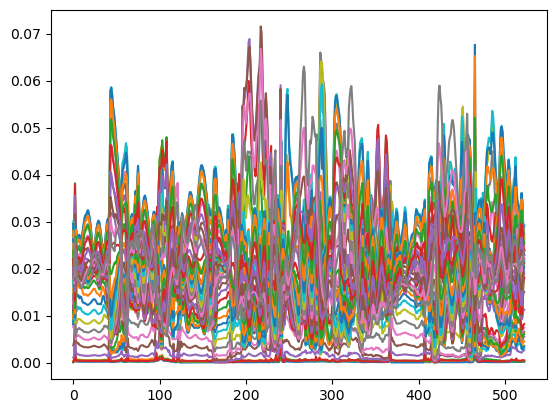

In [182]:
clean_feature_obs=slidingObsWindow(clean_features,120,3,"clean_features")
clean_periodicity_features = extractPeriodicityFeatures(".","clean_features_obs",len(clean_feature_obs),[120])
np.savetxt("clean_obs_per_features.dat",clean_periodicity_features,fmt="%f")
plt.plot(clean_periodicity_features)
plt.show()

Text(0, 0.5, 'Upload (mb/s)')

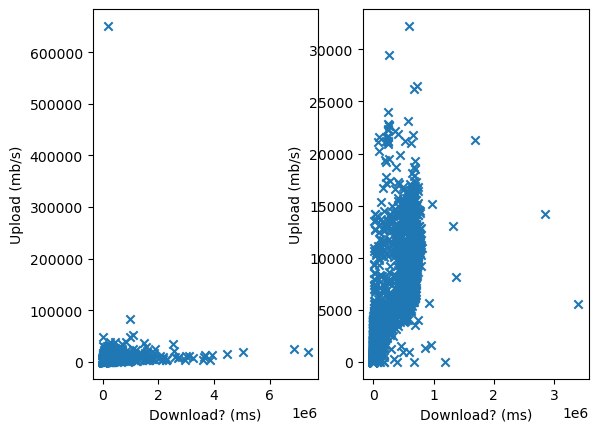

In [185]:
## up_pack (0:media 1:mediana 2:std 3:skew 4:75p 5:90p 6:95p 7:98p //8:len(silence) 9:mean_silence 10:std_silence 11:len(activity) 12:mean_act 13:std_act) ) up_bytes

# 4 colunas (2*up+2*down) * (8 features + 6 do silence^(3*2)) 
#            media mediana std skew 75p 90p 95p 98p
# up_pack     0      1       2   3   4  5   6   7 
# up_bytes    8      9      10  11  12  13  14  15
#down_pack   16      17     18  19  20  21  22  23
#down_byte   24      25     26  27  28  29  30  31


# which features to relate?
# or metrics

# upload/download
plt.subplot(1,2,1)
plt.scatter(clean_data[:, 4], clean_data[:, 2], marker="x")
plt.xlabel("Download? (ms)")
plt.ylabel("Upload (mb/s)")

plt.subplot(1,2,2)
plt.scatter(infected_data[:, 4], infected_data[:, 2], marker="x")
plt.xlabel("Download? (ms)")
plt.ylabel("Upload (mb/s)")


